In [ ]:
"""
Complete Data Curation Script for Plant Diseases - Google Colab Version
Visual Reasoning Baseline - Toy Problem

Extracts ALL disease classes from both datasets:
- Mango Leaf Dataset: 7 disease classes (Foliar Disease Stress)
- Yellow Rust Dataset: 5 disease classes (Disease Severity)
Total: 12 disease classes

Output: Saved to Google Drive
"""

# ============================================================================
# GOOGLE COLAB SETUP
# ============================================================================

# Install required packages
!pip install -q kaggle scikit-learn pillow tqdm pandas

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Setup Kaggle credentials
import os
import json

print("\n" + "="*70)
print("KAGGLE API SETUP")
print("="*70)

# Create the correct .kaggle directory (note: it's .config/kaggle, not .kaggle)
kaggle_dir = '/root/.config/kaggle'
os.makedirs(kaggle_dir, exist_ok=True)

# Create kaggle.json with your credentials
kaggle_credentials = {
    "username": "tirthoroy14999999",
    "key": "a9ed3ab618c3e13b38c03ace223709fc"
}

kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_credentials, f)

# Set proper permissions (required by Kaggle API)
!chmod 600 /root/.config/kaggle/kaggle.json

print(f"\n✓ Kaggle credentials saved to: {kaggle_json_path}")
print("✓ Kaggle API credentials configured successfully!")

# ============================================================================
# IMPORTS
# ============================================================================

import shutil
from pathlib import Path
import difflib
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import random

print("\n✓ All packages imported successfully!")


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def download_with_progress(dataset_name, path="."):
    """Download Kaggle dataset"""
    api = KaggleApi()
    api.authenticate()
    print(f"\nDownloading dataset: {dataset_name}")
    api.dataset_download_files(dataset_name, path=path, unzip=True, quiet=False)
    print("Download complete.")


def get_closest_match(name, options):
    """Find closest matching folder name"""
    matches = difflib.get_close_matches(name, options, n=1, cutoff=0.2)
    return matches[0] if matches else None


def rename_folders(base_directory, expected_classes):
    """Rename folders to match expected class names"""
    print("\nRenaming folders to match expected classes...")
    for folder in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder)
        if os.path.isdir(folder_path):
            closest_match = get_closest_match(folder, expected_classes)
            if closest_match and folder != closest_match:
                new_folder_path = os.path.join(base_directory, closest_match)
                if not os.path.exists(new_folder_path):
                    try:
                        os.rename(folder_path, new_folder_path)
                        print(f"  Renamed '{folder}' → '{closest_match}'")
                    except Exception as e:
                        print(f"  Warning: Could not rename '{folder}': {e}")


def rename_folders_dict(base_directory, rename_dict):
    """Rename folders using a mapping dictionary"""
    print("\nRenaming folders using dictionary...")
    for folder in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder)
        if os.path.isdir(folder_path) and folder in rename_dict:
            new_folder_name = rename_dict[folder]
            new_folder_path = os.path.join(base_directory, new_folder_name)
            if folder != new_folder_name and not os.path.exists(new_folder_path):
                try:
                    os.rename(folder_path, new_folder_path)
                    print(f"  Renamed '{folder}' → '{new_folder_name}'")
                except Exception as e:
                    print(f"  Warning: Could not rename '{folder}': {e}")


# ============================================================================
# DATASET LOADERS
# ============================================================================

def load_mango_leaf_data():
    """Load Mango Leaf Disease dataset - returns all disease classes (excluding Healthy)"""
    print("\n" + "="*70)
    print("LOADING MANGO LEAF DATASET - Foliar Disease Stress")
    print("="*70)

    dataset_name = "aryashah2k/mango-leaf-disease-dataset"
    download_path = "/content/data/mango-leaf-disease-dataset"

    # Download if not exists
    if not os.path.exists(download_path):
        download_with_progress(dataset_name, path=download_path)
    else:
        print(f"\nDataset already exists at {download_path}. Skipping download.")

    base_directory = download_path

    # All classes from Mango Leaf (Foliar Disease Stress)
    all_classes = [
        'Anthracnose',
        'Bacterial Canker',
        'Cutting Weevil',
        'Die Back',
        'Gall Midge',
        'Healthy',  # Will be excluded
        'Powdery Mildew',
        'Sooty Mould'
    ]

    # Classes to exclude (healthy/no disease)
    exclude_classes = ['Healthy']

    # Rename folders
    rename_folders(base_directory, all_classes)

    # Collect images by class (excluding healthy)
    data_by_class = {}
    print("\nCollecting images from Mango Leaf dataset (Type: Foliar Disease Stress):")
    for class_name in all_classes:
        if class_name in exclude_classes:
            print(f"  {class_name}: SKIPPED (healthy class)")
            continue

        class_path = os.path.join(base_directory, class_name)
        if os.path.isdir(class_path):
            images = []
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    images.append(os.path.join(class_path, filename))
            data_by_class[class_name] = images
            print(f"  {class_name}: {len(images)} images [Foliar Disease Stress]")
        else:
            print(f"  WARNING: {class_name} folder not found!")
            data_by_class[class_name] = []

    return data_by_class


def load_yellow_rust_data():
    """Load Yellow Rust dataset - returns all disease classes (excluding No disease)"""
    print("\n" + "="*70)
    print("LOADING YELLOW RUST DATASET - Disease Severity")
    print("="*70)

    dataset_name = "tolgahayit/yellowrust19-yellow-rust-disease-in-wheat"
    download_path = "/content/data/yellowrust19-yellow-rust-disease-in-wheat"

    # Download if not exists
    if not os.path.exists(download_path):
        download_with_progress(dataset_name, path=download_path)
    else:
        print(f"\nDataset already exists at {download_path}. Skipping download.")

    base_directory = os.path.join(download_path, 'YELLOW-RUST-19', 'YELLOW-RUST-19')

    # Mapping for folder renaming
    rename_dict = {
        'MR': 'Moderately Resistant (MR)',
        'MS': 'Moderately Susceptible (MS)',
        'MRMS': 'MRMS',
        '0': 'No disease (0)',
        'R': 'Resistant (R)',
        'S': 'Susceptible (S)'
    }

    # Rename folders
    rename_folders_dict(base_directory, rename_dict)

    # All classes from Yellow Rust (Disease Severity)
    all_classes = [
        'Moderately Resistant (MR)',
        'Moderately Susceptible (MS)',
        'MRMS',
        'No disease (0)',  # Will be excluded
        'Resistant (R)',
        'Susceptible (S)'
    ]

    # Classes to exclude (healthy/no disease)
    exclude_classes = ['No disease (0)']

    # Collect images by class (excluding no disease)
    data_by_class = {}
    print("\nCollecting images from Yellow Rust dataset (Type: Disease Severity):")
    for class_name in all_classes:
        if class_name in exclude_classes:
            print(f"  {class_name}: SKIPPED (no disease class)")
            continue

        class_path = os.path.join(base_directory, class_name)
        if os.path.isdir(class_path):
            images = []
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    images.append(os.path.join(class_path, filename))
            data_by_class[class_name] = images
            print(f"  {class_name}: {len(images)} images [Disease Severity]")
        else:
            print(f"  WARNING: {class_name} folder not found!")
            data_by_class[class_name] = []

    return data_by_class


def sample_and_copy_images(image_paths, disease_dir, disease_name, images_per_disease, random_state):
    """Helper function to sample and copy images"""
    if len(image_paths) == 0:
        print(f"  ERROR: No images found for {disease_name}!")
        return 0

    num_to_sample = min(images_per_disease, len(image_paths))

    # Random sampling with fixed seed
    random.seed(random_state)
    sampled_paths = random.sample(image_paths, num_to_sample)

    # Copy images with progress bar
    copied_count = 0
    for idx, src_path in enumerate(tqdm(sampled_paths, desc=f"  Copying images", leave=False)):
        ext = os.path.splitext(src_path)[1]
        dst_filename = f"{disease_name.replace(' ', '_').replace('(', '').replace(')', '')}_{idx+1:03d}{ext}"
        dst_path = os.path.join(disease_dir, dst_filename)

        try:
            shutil.copy2(src_path, dst_path)
            copied_count += 1
        except Exception as e:
            print(f"  Error copying {src_path}: {e}")

    return copied_count


# ============================================================================
# MAIN CURATION FUNCTION
# ============================================================================

def curate_all_diseases(output_dir, images_per_disease=10):
    """
    Curate ALL disease classes from both datasets (excluding healthy/no disease):
    - Mango Leaf: 7 disease classes (Foliar Disease Stress)
    - Yellow Rust: 5 disease classes (Disease Severity)
    Total: 12 disease classes

    Args:
        output_dir: Directory to save curated dataset (Google Drive path)
        images_per_disease: Number of images to sample per disease (default: 10)
    """

    print("\n" + "="*70)
    print("PLANT DISEASE DATA CURATION")
    print("Target: All disease classes × {} images each".format(images_per_disease))
    print("Dataset Types:")
    print("  - Foliar Disease Stress (Mango Leaf)")
    print("  - Disease Severity (Yellow Rust)")
    print("Excluding: Healthy and No disease classes")
    print(f"Output: {output_dir}")
    print("="*70)

    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    foliar_stress_dir = os.path.join(output_dir, "Foliar_Disease_Stress")
    disease_severity_dir = os.path.join(output_dir, "Disease_Severity")
    os.makedirs(foliar_stress_dir, exist_ok=True)
    os.makedirs(disease_severity_dir, exist_ok=True)

    # Load datasets
    mango_data = load_mango_leaf_data()
    yellow_rust_data = load_yellow_rust_data()

    # Show collected classes
    print("\n" + "="*70)
    print(f"TOTAL DISEASE CLASSES COLLECTED: {len(mango_data) + len(yellow_rust_data)}")
    print("="*70)

    print("\n[FOLIAR DISEASE STRESS] - Mango Leaf diseases:")
    for disease_name in mango_data.keys():
        print(f"  - {disease_name}")

    print("\n[DISEASE SEVERITY] - Yellow Rust diseases:")
    for disease_name in yellow_rust_data.keys():
        print(f"  - {disease_name}")

    # Sample and copy images
    print("\n" + "="*70)
    print("SAMPLING AND COPYING IMAGES")
    print("="*70)

    random_state = 42
    metadata = {
        "total_diseases": 0,
        "images_per_disease": images_per_disease,
        "output_directory": output_dir,
        "foliar_disease_stress": {
            "description": "Mango Leaf - Different types of foliar diseases",
            "count": 0,
            "diseases": []
        },
        "disease_severity": {
            "description": "Yellow Rust - Disease severity levels",
            "count": 0,
            "diseases": []
        }
    }

    # Process Mango Leaf (Foliar Disease Stress)
    print("\n" + "-"*70)
    print("PROCESSING FOLIAR DISEASE STRESS (Mango Leaf)")
    print("-"*70)

    for disease_name, image_paths in mango_data.items():
        print(f"\n[Foliar Disease Stress] Processing: {disease_name}")

        # Create disease directory under Foliar_Disease_Stress
        disease_dir = os.path.join(foliar_stress_dir, disease_name.replace(" ", "_").replace("(", "").replace(")", ""))
        os.makedirs(disease_dir, exist_ok=True)

        # Sample and copy images
        copied_count = sample_and_copy_images(image_paths, disease_dir, disease_name, images_per_disease, random_state)

        print(f"  ✓ Copied {copied_count} images to Foliar_Disease_Stress/{disease_name.replace(' ', '_')}")

        # Update metadata
        metadata["foliar_disease_stress"]["diseases"].append({
            "name": disease_name,
            "type": "Foliar Disease Stress",
            "num_images": copied_count,
            "directory": disease_dir
        })

    metadata["foliar_disease_stress"]["count"] = len(metadata["foliar_disease_stress"]["diseases"])

    # Process Yellow Rust (Disease Severity)
    print("\n" + "-"*70)
    print("PROCESSING DISEASE SEVERITY (Yellow Rust)")
    print("-"*70)

    for disease_name, image_paths in yellow_rust_data.items():
        print(f"\n[Disease Severity] Processing: {disease_name}")

        # Create disease directory under Disease_Severity
        disease_dir = os.path.join(disease_severity_dir, disease_name.replace(" ", "_").replace("(", "").replace(")", ""))
        os.makedirs(disease_dir, exist_ok=True)

        # Sample and copy images
        copied_count = sample_and_copy_images(image_paths, disease_dir, disease_name, images_per_disease, random_state)

        print(f"  ✓ Copied {copied_count} images to Disease_Severity/{disease_name.replace(' ', '_')}")

        # Update metadata
        metadata["disease_severity"]["diseases"].append({
            "name": disease_name,
            "type": "Disease Severity",
            "num_images": copied_count,
            "directory": disease_dir
        })

    metadata["disease_severity"]["count"] = len(metadata["disease_severity"]["diseases"])
    metadata["total_diseases"] = metadata["foliar_disease_stress"]["count"] + metadata["disease_severity"]["count"]

    # Save metadata
    metadata_path = os.path.join(output_dir, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print("\n" + "="*70)
    print("CURATION COMPLETE!")
    print("="*70)
    print(f"\n✓ Output saved to Google Drive: {output_dir}")
    print(f"✓ Total diseases: {metadata['total_diseases']}")
    print(f"  - Foliar Disease Stress: {metadata['foliar_disease_stress']['count']} diseases")
    print(f"  - Disease Severity: {metadata['disease_severity']['count']} diseases")
    print(f"✓ Images per disease: {images_per_disease}")
    print(f"✓ Metadata saved to: {metadata_path}")

    # Print summary
    print("\n" + "="*70)
    print("SUMMARY - FOLIAR DISEASE STRESS (Mango Leaf)")
    print("="*70)
    for disease_info in metadata["foliar_disease_stress"]["diseases"]:
        print(f"  {disease_info['name']}: {disease_info['num_images']} images")

    print("\n" + "="*70)
    print("SUMMARY - DISEASE SEVERITY (Yellow Rust)")
    print("="*70)
    for disease_info in metadata["disease_severity"]["diseases"]:
        print(f"  {disease_info['name']}: {disease_info['num_images']} images")

    # Create a summary text file
    summary_path = os.path.join(output_dir, "DATASET_SUMMARY.txt")
    with open(summary_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("PLANT DISEASE DATASET - CURATION SUMMARY\n")
        f.write("="*70 + "\n\n")
        f.write(f"Total Diseases: {metadata['total_diseases']}\n")
        f.write(f"Images per Disease: {images_per_disease}\n")
        f.write(f"Total Images: {metadata['total_diseases'] * images_per_disease}\n\n")

        f.write("-"*70 + "\n")
        f.write("FOLIAR DISEASE STRESS (Mango Leaf) - 7 diseases\n")
        f.write("-"*70 + "\n")
        for disease_info in metadata["foliar_disease_stress"]["diseases"]:
            f.write(f"  {disease_info['name']}: {disease_info['num_images']} images\n")

        f.write("\n" + "-"*70 + "\n")
        f.write("DISEASE SEVERITY (Yellow Rust) - 5 diseases\n")
        f.write("-"*70 + "\n")
        for disease_info in metadata["disease_severity"]["diseases"]:
            f.write(f"  {disease_info['name']}: {disease_info['num_images']} images\n")

    print(f"\n✓ Summary saved to: {summary_path}")

    return metadata


# ============================================================================
# RUN CURATION
# ============================================================================

# Set output directory in Google Drive
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/Plant_Disease_Dataset"

print("\n" + "="*70)
print("STARTING DATA CURATION")
print("="*70)
print(f"\nData will be saved to: {DRIVE_OUTPUT_DIR}")
print("\nThis may take several minutes depending on download speed...")

# Run curation
metadata = curate_all_diseases(
    output_dir=DRIVE_OUTPUT_DIR,
    images_per_disease=10
)

print("\n" + "="*70)
print("✓✓✓ DATA CURATION COMPLETED SUCCESSFULLY! ✓✓✓")
print("="*70)
print(f"\n✓ Check your Google Drive at: {DRIVE_OUTPUT_DIR}")
print(f"✓ Total {metadata['total_diseases']} disease classes curated")
print(f"✓ Total {metadata['total_diseases'] * metadata['images_per_disease']} images")
print("\n✓ Files created:")
print("  - Foliar_Disease_Stress/ (7 disease folders)")
print("  - Disease_Severity/ (5 disease folders)")
print("  - metadata.json")
print("  - DATASET_SUMMARY.txt")

Mounted at /content/drive

KAGGLE API SETUP

✓ Kaggle credentials saved to: /root/.config/kaggle/kaggle.json
✓ Kaggle API credentials configured successfully!

✓ All packages imported successfully!

STARTING DATA CURATION

Data will be saved to: /content/drive/MyDrive/Plant_Disease_Dataset

This may take several minutes depending on download speed...

PLANT DISEASE DATA CURATION
Target: All disease classes × 10 images each
Dataset Types:
  - Foliar Disease Stress (Mango Leaf)
  - Disease Severity (Yellow Rust)
Excluding: Healthy and No disease classes
Output: /content/drive/MyDrive/Plant_Disease_Dataset

LOADING MANGO LEAF DATASET - Foliar Disease Stress

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset


100%|██████████| 103M/103M [00:00<00:00, 1.31GB/s]

Download complete.

Renaming folders to match expected classes...

  Anthracnose: 500 images [Foliar Disease Stress]
  Bacterial Canker: 500 images [Foliar Disease Stress]
  Cutting Weevil: 500 images [Foliar Disease Stress]
  Die Back: 500 images [Foliar Disease Stress]
  Gall Midge: 500 images [Foliar Disease Stress]
  Healthy: SKIPPED (healthy class)
  Powdery Mildew: 500 images [Foliar Disease Stress]
  Sooty Mould: 500 images [Foliar Disease Stress]

LOADING YELLOW RUST DATASET - Disease Severity

Dataset URL: https://www.kaggle.com/datasets/tolgahayit/yellowrust19-yellow-rust-disease-in-wheat


KeyboardInterrupt: 

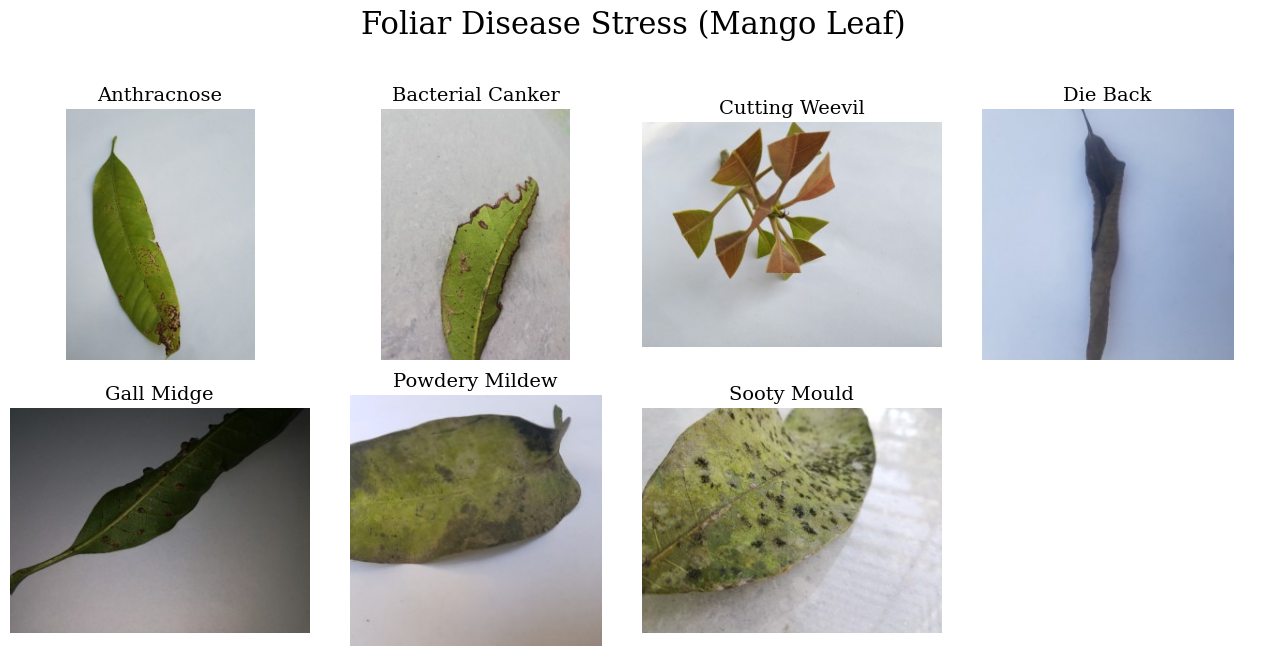

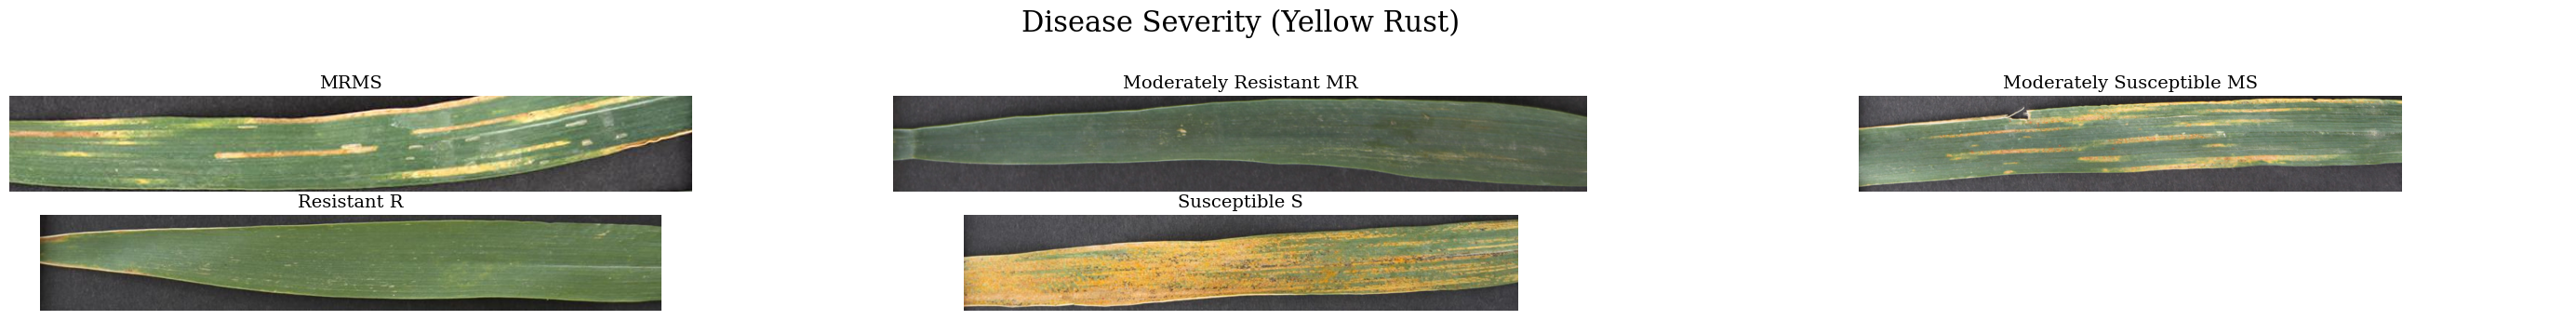

In [ ]:
# ============================================================
# PERFECT SEGMENTED COLLAGE VISUALIZATION (COLAB)
# Foliar Disease Stress vs Disease Severity
# Pixel-faithful | One image per class | NO WARNINGS
# ============================================================

import os
import math
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

# ------------------------------------------------------------
# 🔇 Disable matplotlib font warnings
# ------------------------------------------------------------
warnings.filterwarnings(
    "ignore",
    message="findfont: Generic family"
)

# ------------------------------------------------------------
# ✅ Set a font that EXISTS in Colab
# ------------------------------------------------------------
mpl.rcParams["font.family"] = "DejaVu Serif"   # or "DejaVu Sans"
mpl.rcParams["axes.unicode_minus"] = False

BASE_DIR = "/content/drive/MyDrive/Plant_Disease_Dataset"

# ------------------------------------------------------------
# Helper function: pixel-faithful collage
# ------------------------------------------------------------
def show_collage(group_dir, group_title, cols):
    images = []
    labels = []

    for cls in sorted(os.listdir(group_dir)):
        cls_path = os.path.join(group_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        img_name = sorted(os.listdir(cls_path))[0]
        img_path = os.path.join(cls_path, img_name)

        img = Image.open(img_path)
        images.append(img)
        labels.append(cls.replace("_", " "))

    n = len(images)
    rows = math.ceil(n / cols)

    max_w = max(img.size[0] for img in images)
    max_h = max(img.size[1] for img in images)

    fig_w = cols * max_w / 100
    fig_h = rows * max_h / 100

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), dpi=100)
    axes = axes.flatten()

    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)
        ax.set_title(label, fontsize=14)
        ax.axis("off")

    for ax in axes[len(images):]:
        ax.axis("off")

    plt.suptitle(group_title, fontsize=22, y=1.02)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 1️⃣ Foliar Disease Stress (Mango Leaf)
# ------------------------------------------------------------
show_collage(
    os.path.join(BASE_DIR, "Foliar_Disease_Stress"),
    "Foliar Disease Stress (Mango Leaf)",
    cols=4
)

# ------------------------------------------------------------
# 2️⃣ Disease Severity (Yellow Rust)
# ------------------------------------------------------------
show_collage(
    os.path.join(BASE_DIR, "Disease_Severity"),
    "Disease Severity (Yellow Rust)",
    cols=3
)


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your-openai-api-key-here"

In [ ]:
# total_samples_to_check = 10
# vendor, model, model_name =all_vendors_models[0].values() # index 2 is gemini, 3 is llava

# load all the modules local again instead of cache
# %load_ext autoreload
# %autoreload 2
# Import the required libraries
import os
import json
import base64
import asyncio
import aiohttp
import time
#from anthropic import Anthropic
from PIL import Image
import io
import pandas as pd
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import nest_asyncio
from tqdm import tqdm
import re
from pathlib import Path
nest_asyncio.apply()
global vision_prompt

# ============================================================================
# DISEASE REASONING DESCRIPTIONS
# ============================================================================

FOLIAR_DISEASE_DESCRIPTIONS = {
    "Anthracnose": """
        **Symptoms**: Caused by Colletotrichum fungus. Produces necrotic lesions that expand over time.
        Often begins at leaf tips or margins. Severe cases cause leaf blight and premature leaf drop.

        **Visual Identifiers**:
        - Dark brown to black irregular lesions
        - Lesions often have defined margins
        - Tip or edge-originating damage
        - Necrotic regions contrast clearly with healthy green tissue

        **Potential Confusions**: Early-stage may resemble minor physical damage. Brown discoloration
        can be confused with nutrient stress.
    """,

    "Bacterial_Canker": """
        **Symptoms**: Caused by Xanthomonas species. Leads to tissue cracking and canker formation.
        Often spreads along veins.

        **Visual Identifiers**:
        - Raised, corky, or cracked lesions
        - Water-soaked appearance around lesions
        - Irregular lesion edges following vascular structure
        - Marginal leaf deformation

        **Potential Confusions**: Lesions may resemble insect damage scars. Color similarity to
        anthracnose in later stages.
    """,

    "Cutting_Weevil": """
        **Symptoms**: Caused by insect feeding. Weevils cut leaf stalks, causing detached or hanging
        leaves. Not a pathogen-induced disease.

        **Visual Identifiers**:
        - Clean-cut leaf petioles
        - Leaves appear wilted but not necrotic
        - Absence of spots, mold, or discoloration
        - Structural damage dominates over color change

        **Potential Confusions**: Leaf drying may mimic die-back. Detached leaves could be mistaken
        for mechanical damage.
    """,

    "Die_Back": """
        **Symptoms**: Progressive death of leaf tissue from tip downward. Often associated with
        fungal infection or nutrient imbalance.

        **Visual Identifiers**:
        - Uniform darkening starting from the leaf tip
        - Sharp transition from dead (black/brown) to live tissue
        - Leaf appears shriveled or dried
        - No discrete spots—continuous necrosis

        **Potential Confusions**: Can be confused with drought stress. Physical damage may produce
        similar tip necrosis.
    """,

    "Gall_Midge": """
        **Symptoms**: Caused by insect larvae forming galls. Affects leaf development and structure.

        **Visual Identifiers**:
        - Swollen, thickened regions
        - Leaf deformation or curling
        - Uneven surface texture
        - Localized growth abnormalities rather than discoloration

        **Potential Confusions**: Early galls may be subtle. Can resemble nutrient-induced leaf curling.
    """,

    "Powdery_Mildew": """
        **Symptoms**: Fungal disease affecting leaf surfaces. Reduces photosynthesis.

        **Visual Identifiers**:
        - White or gray powder-like coating
        - Diffuse texture over leaf surface
        - Yellowing beneath fungal growth
        - Matte appearance compared to healthy leaves

        **Potential Confusions**: Dust or residue can mimic mildew. Early-stage mildew may not show
        visible powder.
    """,

    "Sooty_Mould": """
        **Symptoms**: Grows on honeydew secreted by insects. Does not infect plant tissue directly.

        **Visual Identifiers**:
        - Black, soot-like fungal layer
        - Patchy or widespread surface coverage
        - Can often be rubbed off
        - Leaf tissue underneath may remain green

        **Potential Confusions**: Shadowing or dirt can appear similar. Severe cases obscure leaf
        texture entirely.
    """
}


DISEASE_SEVERITY_DESCRIPTIONS = {
    "MRMS": """
        **Symptoms**: Heterogeneous host response. Patchy resistance.

        **Visual Identifiers**:
        - Mixed green and yellow regions
        - Uneven pustule distribution
        - Coexistence of healthy and infected tissue

        **Potential Confusions**: Ambiguous boundary between classes. Often mislabeled in
        single-image classification.
    """,

    "Moderately_Resistant_MR": """
        **Symptoms**: Limited pathogen growth. Delayed disease progression.

        **Visual Identifiers**:
        - Sparse yellow streaks
        - Pustules small and discontinuous
        - Damage restricted to isolated regions

        **Potential Confusions**: Similar to early MS stage. Requires spatial pattern awareness.
    """,

    "Moderately_Susceptible_MS": """
        **Symptoms**: Moderate infection. Active spore production.

        **Visual Identifiers**:
        - Multiple yellow-orange pustules
        - Linear streaks along leaf veins
        - Visible disease progression

        **Potential Confusions**: Can overlap visually with MR or S. Lighting exaggerates severity.
    """,

    "Resistant_R": """
        **Symptoms**: Minimal pathogen development. Strong host defense response.

        **Visual Identifiers**:
        - Mostly green leaf surface
        - Few or no visible pustules
        - Normal leaf texture and color

        **Potential Confusions**: Early infection stages may be invisible.
    """,

    "Susceptible_S": """
        **Symptoms**: Severe infection. High spore density.

        **Visual Identifiers**:
        - Dense yellow/orange rust coverage
        - Large contiguous infected regions
        - Leaf discoloration dominates healthy tissue

        **Potential Confusions**: Severe nutrient deficiency may resemble yellowing.
    """
}

# ============================================================================
# DATA LOADER FROM GOOGLE DRIVE
# ============================================================================

def load_data_from_drive(dataset_path, dataset_type, num_samples=None):
    """
    Load dataset directly from Google Drive structure

    Args:
        dataset_path: Path to Plant_Disease_Dataset directory
        dataset_type: "Foliar_Disease_Stress" or "Disease_Severity"
        num_samples: Number of samples to load (None = all)

    Returns:
        DataFrame with columns [image_path, true_label]
        List of expected classes
        Output file name
    """
    data = []
    dataset_dir = Path(dataset_path) / dataset_type

    if not dataset_dir.exists():
        raise ValueError(f"Dataset directory not found: {dataset_dir}")

    print(f"\nLoading from: {dataset_dir}")

    # Iterate through disease class folders
    for class_folder in sorted(dataset_dir.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name

            # Get all images
            images = (list(class_folder.glob("*.jpg")) +
                     list(class_folder.glob("*.jpeg")) +
                     list(class_folder.glob("*.png")))

            # Add to data list
            for img_file in images:
                data.append([str(img_file), class_name])

    # Create DataFrame
    df = pd.DataFrame(data, columns=[0, 1])  # Keep column names as 0, 1 for compatibility

    # Shuffle
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Limit samples if specified
    if num_samples is not None and num_samples < len(df):
        # Stratified sampling to keep balanced classes
        sampled_dfs = []
        for class_name in df[1].unique():
            class_df = df[df[1] == class_name]
            n_samples = min(len(class_df), num_samples // df[1].nunique())
            sampled_dfs.append(class_df.sample(n=n_samples, random_state=42))
        df = pd.concat(sampled_dfs, ignore_index=True)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle again

    # Get expected classes
    expected_classes = sorted(df[1].unique().tolist())

    # Create output filename
    output_file_name = dataset_type.lower()

    print(f"  Loaded {len(df)} images")
    print(f"  Classes ({len(expected_classes)}): {expected_classes}")

    return df, expected_classes, output_file_name

# ============================================================================
# REASONING PROMPT BUILDER - NEW FUNCTION
# ============================================================================

def create_reasoning_prompt(expected_classes, dataset_name="", use_reasoning=True):
    """
    Create either a reasoning-enhanced prompt or baseline prompt

    Args:
        expected_classes: List of class names
        dataset_name: Name of the dataset (to determine which descriptions to use)
        use_reasoning: If True, use reasoning descriptions; if False, use baseline

    Returns:
        Formatted prompt string
    """

    if not use_reasoning:
        # Return baseline prompt (original)
        return f"""Given the image, identify the class. Use the following list of possible classes for your prediction It should be one of the : {expected_classes}. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
{{"prediction": "class_name"}}
Replace "class_name" with the appropriate class from the list above based on your analysis of the image.
The labels should be entered exactly as they are in the list above i.e., {expected_classes}.
The response should start with {{ and contain only a JSON object (as specified above) and no other text."""

    # Determine which descriptions to use
    descriptions_dict = {}
    if "foliar" in dataset_name.lower():
        # Use foliar disease descriptions - direct matching with folder names
        for class_name in expected_classes:
            if class_name in FOLIAR_DISEASE_DESCRIPTIONS:
                descriptions_dict[class_name] = FOLIAR_DISEASE_DESCRIPTIONS[class_name]

    elif "severity" in dataset_name.lower() or "disease_severity" in dataset_name.lower():
        # Use disease severity descriptions - direct matching with folder names
        for class_name in expected_classes:
            if class_name in DISEASE_SEVERITY_DESCRIPTIONS:
                descriptions_dict[class_name] = DISEASE_SEVERITY_DESCRIPTIONS[class_name]

    # If we found descriptions, create reasoning prompt
    if descriptions_dict:
        descriptions_text = "\n\n".join([
            f"**{class_name}**:\n{desc.strip()}"
            for class_name, desc in descriptions_dict.items()
        ])

        return f"""You are an expert agricultural pathologist analyzing plant disease images.

**Task**: Identify the disease class from this image.

**Possible Classes and Their Characteristics**:

{descriptions_text}

**Analysis Instructions**:
1. Carefully examine the image for visual symptoms
2. Compare observed features against the disease descriptions above
3. Pay attention to:
   - Lesion characteristics (color, shape, location)
   - Texture patterns (smooth, powdery, cracked)
   - Distribution patterns (localized, diffuse, tip-originated)
   - Color changes (yellowing, browning, blackening)
4. Consider potential confusions mentioned in each description
5. Make your classification based on the strongest visual evidence

**Expected Classes**: {expected_classes}

**Output Format**:
Provide your answer as a JSON object:
{{"prediction": "class_name"}}

The class_name must EXACTLY match one of: {expected_classes}

**Important**:
- Be attentive to subtle details as some classes may appear similar
- The response should start with {{ and contain ONLY the JSON object
- No additional text or explanation"""

    else:
        # Fall back to baseline if no descriptions found
        return f"""Given the image, identify the class. Use the following list of possible classes for your prediction It should be one of the : {expected_classes}. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
{{"prediction": "class_name"}}
Replace "class_name" with the appropriate class from the list above based on your analysis of the image.
The labels should be entered exactly as they are in the list above i.e., {expected_classes}.
The response should start with {{ and contain only a JSON object (as specified above) and no other text."""

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def compute_metrics(y_true, y_pred):
    """Compute classification metrics, filtering out 'NA' predictions"""
    # Filter out 'NA' predictions
    valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    if len(y_pred_filtered) == 0:
        return {
            'accuracy': 0.0,
            'precision_macro': 0.0,
            'recall_macro': 0.0,
            'f1_macro': 0.0,
            'num_valid': 0,
            'num_total': len(y_pred)
        }

    return {
        'accuracy': accuracy_score(y_true_filtered, y_pred_filtered),
        'precision_macro': precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'num_valid': len(y_pred_filtered),
        'num_total': len(y_pred)
    }

def save_metrics_report(results_df, output_file, expected_classes, shots_list):
    """Save detailed metrics report alongside results CSV"""
    metrics_output = output_file.replace('.csv', '_METRICS.txt')

    with open(metrics_output, 'w') as f:
        f.write("="*70 + "\n")
        f.write("CLASSIFICATION METRICS REPORT\n")
        f.write("="*70 + "\n\n")

        for num_shots in shots_list:
            col_name = f"# of Shots {num_shots}"
            if col_name in results_df.columns:
                y_true = results_df.iloc[:, 1].tolist()  # True labels (column 1)
                y_pred = results_df[col_name].tolist()

                metrics = compute_metrics(y_true, y_pred)

                f.write(f"\n{num_shots}-SHOT RESULTS:\n")
                f.write("-"*70 + "\n")
                f.write(f"Accuracy:        {metrics['accuracy']:.4f}\n")
                f.write(f"Precision (Macro): {metrics['precision_macro']:.4f}\n")
                f.write(f"Recall (Macro):    {metrics['recall_macro']:.4f}\n")
                f.write(f"F1 Score (Macro):  {metrics['f1_macro']:.4f}\n")
                f.write(f"Valid Predictions: {metrics['num_valid']} / {metrics['num_total']}\n")

                # Add per-class report for 0-shot
                if num_shots == 0:
                    valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
                    y_true_filtered = [y_true[i] for i in valid_indices]
                    y_pred_filtered = [y_pred[i] for i in valid_indices]

                    if len(y_pred_filtered) > 0:
                        f.write("\nPer-Class Classification Report (0-shot):\n")
                        f.write("-"*70 + "\n")

                        # FIXED: Added labels parameter to prevent mismatch error
                        report = classification_report(
                            y_true_filtered,
                            y_pred_filtered,
                            labels=expected_classes,  # Force sklearn to use only expected classes
                            target_names=expected_classes,
                            zero_division=0
                        )
                        f.write(report)

        f.write("\n" + "="*70 + "\n")

    print(f"  ✓ Metrics report saved to: {metrics_output}")

#claude-3-sonnet-20240229
all_vendors_models=[
    #{"vendor": "openai", "model": "gpt-4o-mini", "model_name": "GPT-4o-mini"},
     {"vendor": "openai", "model": "gpt-4o-2024-05-13", "model_name": "GPT-4o"}, #  done
    # {"vendor": "anthropic", "model": "claude-3-5-sonnet-20240620", "model_name": "Claude-3.5-sonnet"}, #done
    # {"vendor": "anthropic", "model": "claude-3-haiku-20240307", "model_name": "Claude-3-haiku"}, #done
    # {"vendor": "openrouter", "model": "liuhaotian/llava-yi-34b", "model_name": "LLaVA v1.6 34B"}, #done
    # {"vendor": "google", "model": "gemini-1.5-flash-latest", "model_name": "Gemini-flash-1.5"}, #done
    # {"vendor": "google", "model": "gemini-1.5-pro", "model_name": "Gemini-pro-1.5"},#done
]

universal_shots= [0]

# ============================================================================
# DATASET CONFIGURATION - MODIFIED TO LOAD FROM GOOGLE DRIVE
# ============================================================================

# Base path to your Google Drive dataset
DATASET_BASE_PATH = "/content/drive/MyDrive/Plant_Disease_Dataset"

datasets = [
    # FOLIAR DISEASE STRESS - Baseline
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Foliar_Disease_Stress",
        "samples": 70,  # 7 classes × 10 images = 70 total
        "shots": universal_shots,
        "use_reasoning": False,
        "exp_suffix": "_baseline"
    },

    # FOLIAR DISEASE STRESS - Reasoning
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Foliar_Disease_Stress",
        "samples": 70,
        "shots": universal_shots,
        "use_reasoning": True,
        "exp_suffix": "_reasoning"
    },

    # DISEASE SEVERITY - Baseline
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Disease_Severity",
        "samples": 50,  # 5 classes × 10 images = 50 total
        "shots": universal_shots,
        "use_reasoning": False,
        "exp_suffix": "_baseline"
    },

    # DISEASE SEVERITY - Reasoning
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Disease_Severity",
        "samples": 50,
        "shots": universal_shots,
        "use_reasoning": True,
        "exp_suffix": "_reasoning"
    },
]

vision_prompt = ""
def extract_json(s):
    """Extract the first JSON object from a string."""
    json_match = re.search(r'\{.*\}', s, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group())
        except json.JSONDecodeError:
            return None
    return None

def load_image(image_path: str) -> str:
    """
    Load image from file, convert to JPEG, and encode as base64.
    """
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG", quality=95)
            return base64.b64encode(buffer.getvalue()).decode('utf-8')
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

class RateLimiter:
    def __init__(self, max_requests, time_window):
        self.max_requests = max_requests
        self.time_window = time_window
        self.request_times = []

    async def wait(self):
        while True:
            current_time = time.time()
            self.request_times = [t for t in self.request_times if t > current_time - self.time_window]
            if len(self.request_times) < self.max_requests:
                self.request_times.append(current_time)
                break
            await asyncio.sleep(0.1)

class GPTAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = "https://api.openai.com/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }
        # Increased rate limit for GPT-4o-mini
        self.rate_limiter = RateLimiter(max_requests=30, time_window=1)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {"type": "text", "text": inputs['prompt']},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}",
                                "detail": "high"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 4096,
            "temperature": 1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ClaudeAPI:
    def __init__(self, api_key, model):
        self.client = Anthropic(api_key=api_key)
        self.model = model
        self.rate_limiter = RateLimiter(max_requests=5, time_window=2)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": inputs['prompt']},
                    *[
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": ex['image_url']['url'].split(',')[1] if ex['type'] == 'image_url' else ex['source']['data']
                            }
                        }
                        if ex['type'] in ['image_url', 'image'] else ex
                        for ex in inputs['examples']
                    ],
                    {"type": "text", "text": inputs['prompt']},
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": inputs['image']
                        }
                    }
                ]
            }
        ]
        response = self.client.messages.create(
            model=self.model,
            max_tokens=4096,
            temperature=1.0,
            messages=messages
        )
        return response.content[0].text

class OpenRouterAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}",
        }
        self.rate_limiter = RateLimiter(max_requests=15, time_window=5)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {"type": "text", "text": inputs['prompt']},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}"
                            }
                        }
                    ]
                }
            ],
            "temperature":1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class GeminiAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent"
        self.headers = {
            "Content-Type": "application/json",
        }
        self.rate_limiter = RateLimiter(max_requests=15, time_window=5)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()

        gemini_examples = []
        gemini_examples.extend([{"text": inputs['prompt']}])
        for example in inputs['examples']:
            if 'image_url' in example:
                gemini_examples.extend([
                    {"inline_data": {"mime_type": "image/jpeg", "data": example['image_url']['url'].split(',')[1]}}
                ])
            elif 'text' in example:
                gemini_examples.append({"text": example['text']})

        gemini_examples.extend([
            {"inline_data": {"mime_type": "image/jpeg", "data": inputs['image']}}
        ])

        payload = {
            "contents": [
                {
                    "parts": gemini_examples
                }
            ],
            "generationConfig": {
                "temperature": 1.0,
                "maxOutputTokens": 4096,
                "response_mime_type": "application/json",
            }
        }

        async with aiohttp.ClientSession() as session:
            async with session.post(f"{self.url}?key={self.api_key}", headers=self.headers, json=payload) as response:
                result = await response.json()
                if "candidates" in result and result["candidates"]:
                    return result["candidates"][0]['content']['parts'][0]['text']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Processing images")

    def update(self):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

################################################################################################################################################################

async def process_image(api, i, number_of_shots, all_data_results, all_data, progress_bar):
    try:
        image_path = all_data[0][i]
        image_base64 = load_image(image_path)
        if image_base64 is None:
            raise ValueError(f"Failed to load image: {image_path}")

        examples = []
        example_paths = []
        example_categories = []
        num_rows = len(all_data)
        random_indices = random.sample([idx for idx in range(num_rows) if idx != i], number_of_shots)

        for j in random_indices:
            example_image_path = all_data[0][j]
            example_image_base64 = load_image(example_image_path)
            if example_image_base64 is not None:
                if isinstance(api, GPTAPI) or isinstance(api, OpenRouterAPI):
                    examples.append({"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example_image_base64}", "detail": "high"}})
                elif isinstance(api, ClaudeAPI):
                    examples.append({
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": example_image_base64
                        }
                    })
                elif isinstance(api, GeminiAPI):
                    examples.append({"image_url": {"url": f"data:image/jpeg;base64,{example_image_base64}"}})
                else:
                    raise ValueError(f"Unsupported API type: {type(api)}")

                examples.append({"type": "text", "text": f'{{"prediction": "{all_data.at[j, 1]}"}}' })
                example_paths.append(example_image_path)
                example_categories.append(all_data.at[j, 1])

        prediction = await api.get_image_information({"image": image_base64, "examples": examples, "prompt": vision_prompt})

        try:
            extracted_json = extract_json(prediction)
            parsed_prediction = extracted_json['prediction']
        except Exception as e:
            print(f"Error parsing JSON for image {image_path}. API response: {prediction}. Error: {str(e)}")
            parsed_prediction = 'NA'

        all_data_results.at[i, f"# of Shots {number_of_shots}"] = parsed_prediction
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = str(example_paths)
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = str(example_categories)

    except Exception as e:
        print(f"Error processing {all_data[0][i]}: {str(e)}")
        all_data_results.at[i, f"# of Shots {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = 'NA'
    finally:
        progress_bar.update()

async def process_images_for_shots(api, number_of_shots, all_data_results, all_data):
    progress_bar = ProgressBar(len(all_data))
    tasks = []
    for i in range(len(all_data)):
        task = asyncio.ensure_future(process_image(api, i, number_of_shots, all_data_results, all_data, progress_bar))
        tasks.append(task)

    await asyncio.gather(*tasks)
    progress_bar.close()

async def main():

    global vision_prompt

    for dataset in datasets:
        # NEW: Load from Google Drive instead of using loader function
        dataset_path = dataset["dataset_path"]
        dataset_type = dataset["dataset_type"]
        total_samples_to_check = dataset["samples"]
        shots = dataset["shots"]
        use_reasoning = dataset.get("use_reasoning", False)
        exp_suffix = dataset.get("exp_suffix", "")

        # Load data from Google Drive
        all_data, expected_classes, output_file_name = load_data_from_drive(
            dataset_path, dataset_type, total_samples_to_check
        )

        # Append suffix to output filename
        if exp_suffix:
            output_file_name = output_file_name + exp_suffix

        print(f"\n{'='*70}")
        print(f"Dataset Name: {output_file_name}")
        print(f"Number of classes / unique labels: {len(expected_classes)}")
        print(f"Expected classes: {expected_classes}")
        print(f"Using Reasoning: {use_reasoning}")
        print(f"{'='*70}")

        # Create prompt based on reasoning flag
        vision_prompt = create_reasoning_prompt(expected_classes, dataset_type, use_reasoning)
        if use_reasoning:
            print("✓ Using REASONING prompt with detailed disease descriptions")
        else:
            print("✓ Using BASELINE prompt")

        print(f"\nProcessing dataset: {output_file_name}")

        for vendor_model in all_vendors_models:
            vendor = vendor_model["vendor"]
            model = vendor_model["model"]
            model_name = vendor_model["model_name"]

            print(f"\nRunning model: {model_name}")

            if vendor == "openai":
                api = GPTAPI(api_key=os.getenv("OPENAI_API_KEY"), model=model)
            elif vendor == "anthropic":
                api = ClaudeAPI(api_key=os.getenv("ANTHROPIC_API_KEY"), model=model)
            elif vendor == "openrouter":
                api = OpenRouterAPI(api_key=os.getenv("OPENROUTER_API_KEY"), model=model)
            elif vendor == "google":
                api = GeminiAPI(api_key=os.getenv("GOOGLE_API_KEY"), model=model)
            else:
                raise ValueError(f"Unsupported model type: {vendor}")

            all_data_results = all_data.copy(deep=True)
            all_data_results.columns = all_data_results.columns.map(str)

            for number_of_shots in shots:
                print(f"  Running with {number_of_shots} shots")
                await process_images_for_shots(api, number_of_shots, all_data_results, all_data)

            # Create the results directory structure
            results_dir = os.path.join("results", model_name)
            os.makedirs(results_dir, exist_ok=True)

            # Save the results file
            output_file = os.path.join(results_dir, f"{output_file_name}.csv")
            all_data_results.to_csv(output_file)
            print(f"  ✓ Results saved to {output_file}")

            # Save metrics report
            save_metrics_report(all_data_results, output_file, expected_classes, shots)

        print(f"\n✓✓✓ Completed processing for dataset: {output_file_name}\n")


if __name__ == "__main__":
    asyncio.run(main())


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress
  Loaded 70 images
  Classes (7): ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']

Dataset Name: foliar_disease_stress_baseline
Number of classes / unique labels: 7
Expected classes: ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']
Using Reasoning: False
✓ Using BASELINE prompt

Processing dataset: foliar_disease_stress_baseline

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 70/70 [00:03<00:00, 18.73it/s]


  ✓ Results saved to results/GPT-4o/foliar_disease_stress_baseline.csv
  ✓ Metrics report saved to: results/GPT-4o/foliar_disease_stress_baseline_METRICS.txt

✓✓✓ Completed processing for dataset: foliar_disease_stress_baseline


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress
  Loaded 70 images
  Classes (7): ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']

Dataset Name: foliar_disease_stress_reasoning
Number of classes / unique labels: 7
Expected classes: ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']
Using Reasoning: True
✓ Using REASONING prompt with detailed disease descriptions

Processing dataset: foliar_disease_stress_reasoning

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


  ✓ Results saved to results/GPT-4o/foliar_disease_stress_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/foliar_disease_stress_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: foliar_disease_stress_reasoning


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Disease_Severity
  Loaded 50 images
  Classes (5): ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']

Dataset Name: disease_severity_baseline
Number of classes / unique labels: 5
Expected classes: ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']
Using Reasoning: False
✓ Using BASELINE prompt

Processing dataset: disease_severity_baseline

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


  ✓ Results saved to results/GPT-4o/disease_severity_baseline.csv
  ✓ Metrics report saved to: results/GPT-4o/disease_severity_baseline_METRICS.txt

✓✓✓ Completed processing for dataset: disease_severity_baseline


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Disease_Severity
  Loaded 50 images
  Classes (5): ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']

Dataset Name: disease_severity_reasoning
Number of classes / unique labels: 5
Expected classes: ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']
Using Reasoning: True
✓ Using REASONING prompt with detailed disease descriptions

Processing dataset: disease_severity_reasoning

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 50/50 [00:02<00:00, 17.06it/s]

  ✓ Results saved to results/GPT-4o/disease_severity_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/disease_severity_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: disease_severity_reasoning




                    VISUALIZATION SCRIPT STARTED

📂 Loading results from /content/results...
✓ Loaded 4 result configurations
  - Models: ['GPT-4o']
  - Datasets: ['Disease Severity', 'Foliar Disease Stress']
  - Approaches: ['Reasoning', 'Baseline']

📊 Generating visualizations...
✓ Saved comparison plot to: /content/visualizations/comparison_bars.png


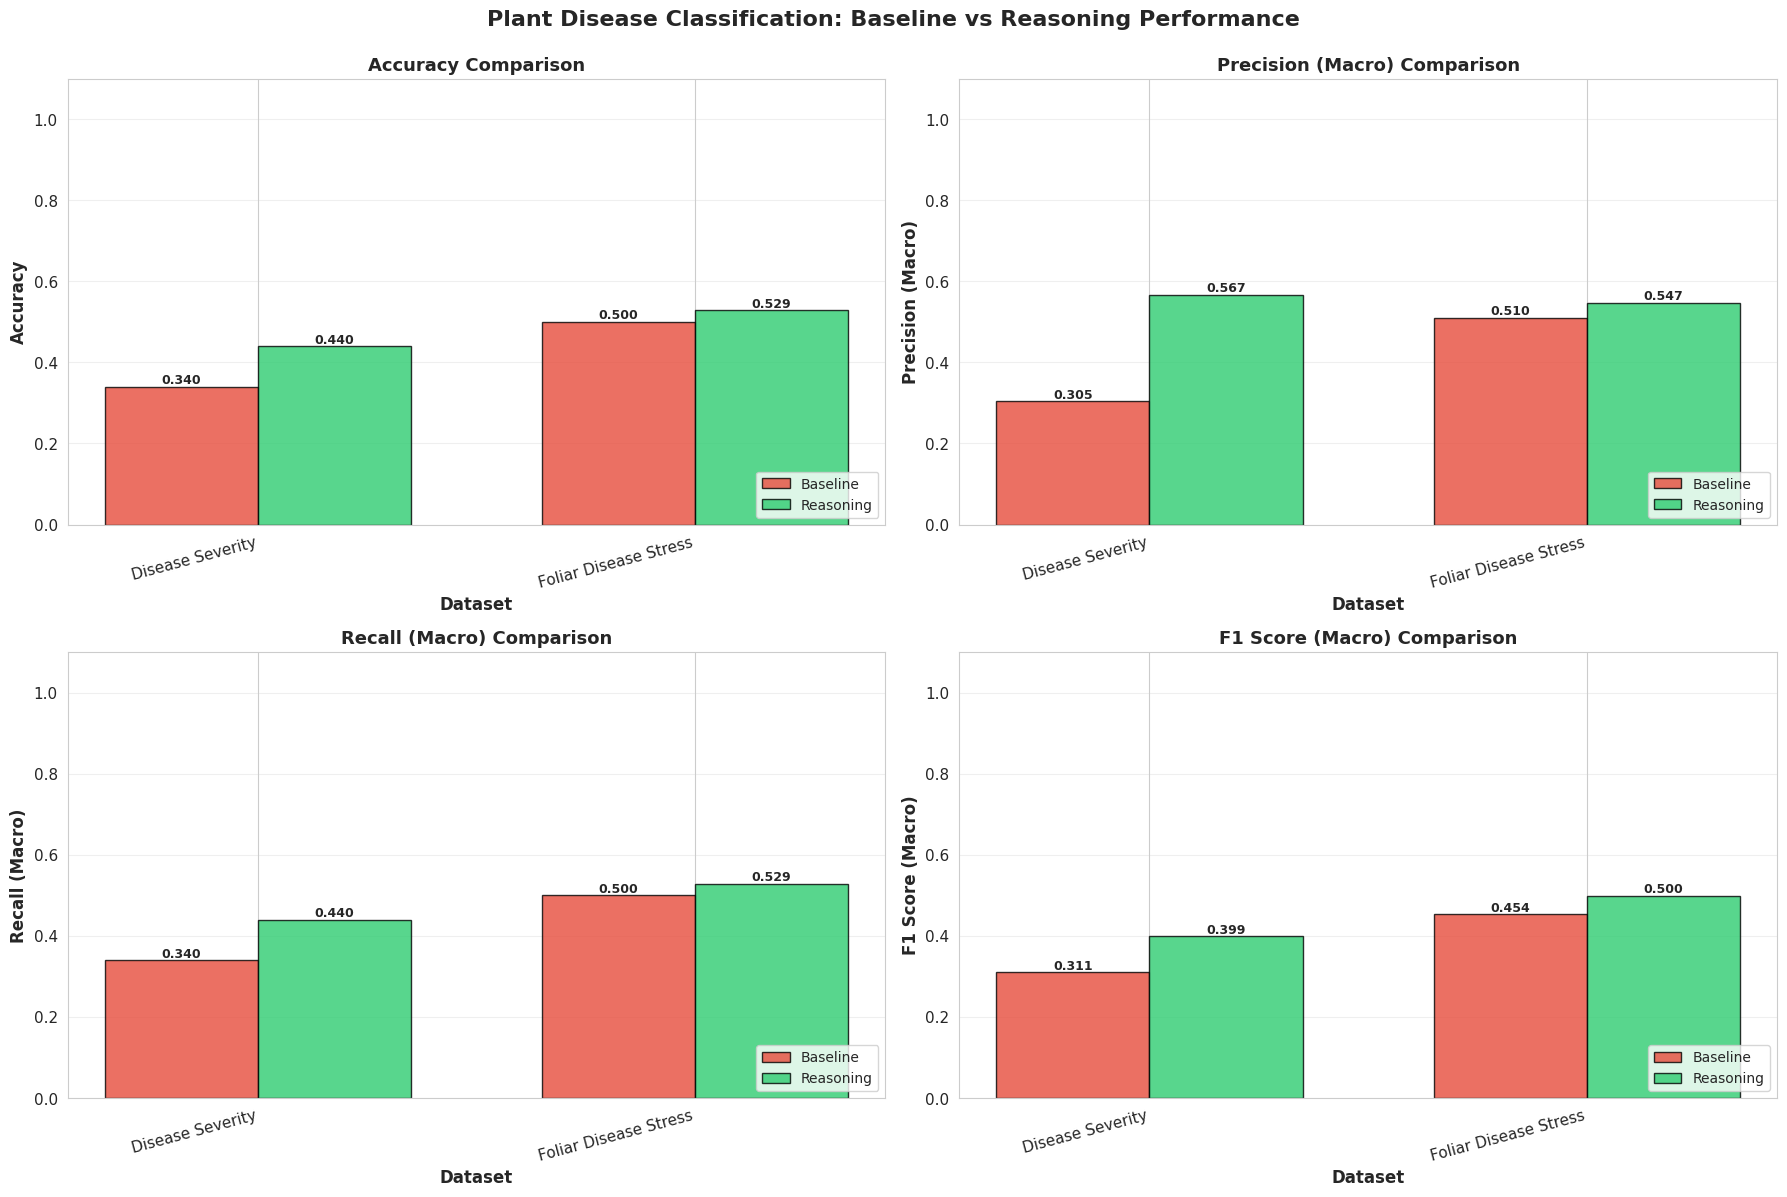

✓ Saved improvement heatmap to: /content/visualizations/improvement_heatmap.png


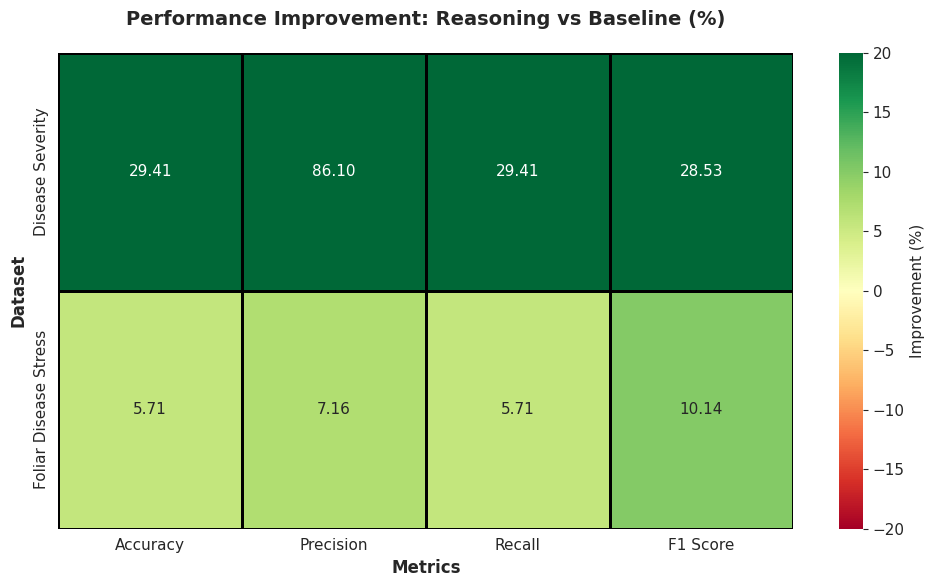

✓ Saved radar chart to: /content/visualizations/radar_comparison.png


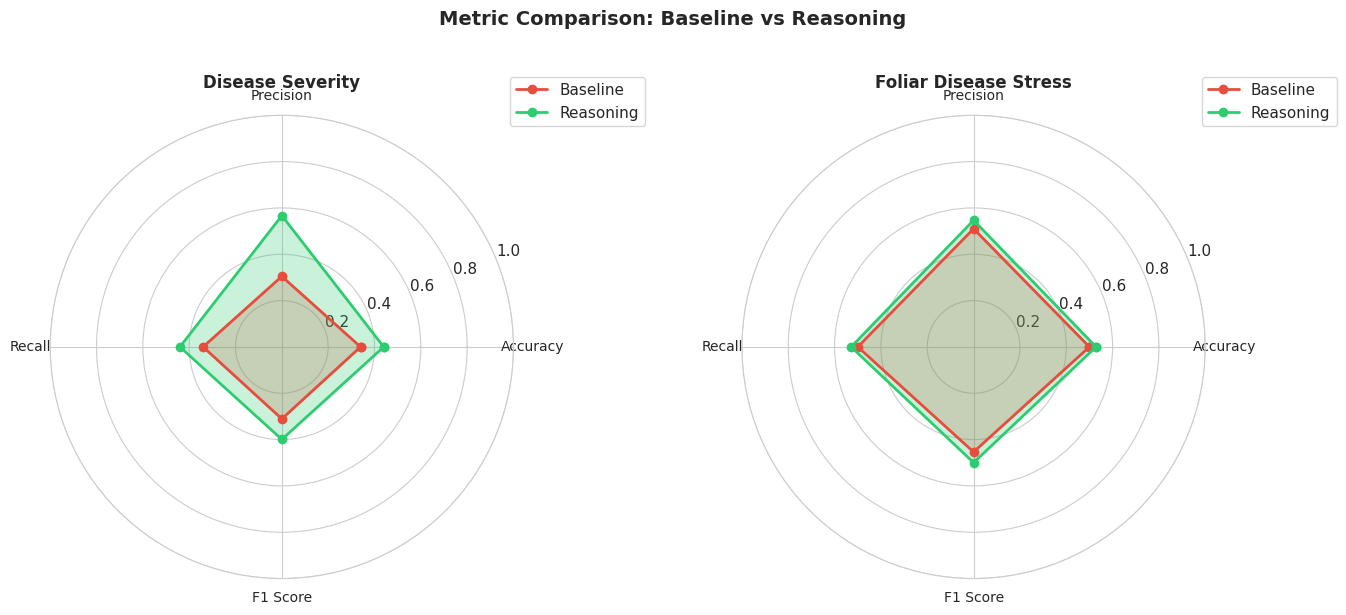

✓ Saved summary table to: /content/visualizations/summary_table.png


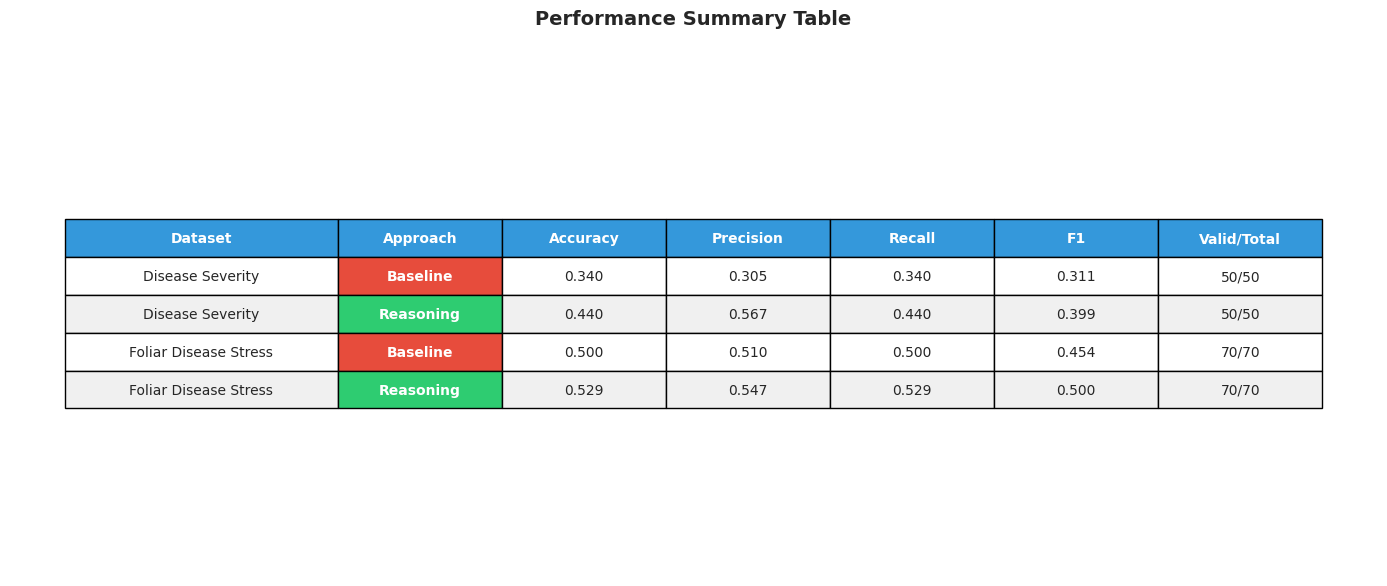


                    PERFORMANCE SUMMARY

────────────────────────────────────────────────────────────────────────────────
📊 DATASET: Disease Severity
────────────────────────────────────────────────────────────────────────────────

  BASELINE:
    • Accuracy:  0.3400 (34.00%)
    • Precision: 0.3045 (30.45%)
    • Recall:    0.3400 (34.00%)
    • F1 Score:  0.3107 (31.07%)
    • Valid Predictions: 50/50

  REASONING:
    • Accuracy:  0.4400 (44.00%)
    • Precision: 0.5667 (56.67%)
    • Recall:    0.4400 (44.00%)
    • F1 Score:  0.3994 (39.94%)
    • Valid Predictions: 50/50

  📈 IMPROVEMENT (Reasoning vs Baseline):
    • Accuracy: +29.41%
    • F1 Score: +28.53%

────────────────────────────────────────────────────────────────────────────────
📊 DATASET: Foliar Disease Stress
────────────────────────────────────────────────────────────────────────────────

  BASELINE:
    • Accuracy:  0.5000 (50.00%)
    • Precision: 0.5102 (51.02%)
    • Recall:    0.5000 (50.00%)
    • F1 Score:  

In [ ]:
"""
Comprehensive Visualization Script for Plant Disease Classification Results
Compares Baseline vs Reasoning approaches across multiple datasets and models
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# ============================================================================
# COLOR PALETTE - Professional and Colorblind-friendly
# ============================================================================

COLORS = {
    'baseline': '#E74C3C',      # Red for baseline
    'reasoning': '#2ECC71',     # Green for reasoning
    'foliar': '#3498DB',        # Blue for foliar
    'severity': '#F39C12',      # Orange for severity
    'gpt4o-mini': '#9B59B6',    # Purple
    'gpt4o': '#1ABC9C',         # Teal
    'claude-sonnet': '#34495E', # Dark gray
    'claude-haiku': '#95A5A6',  # Light gray
    'gemini-flash': '#E67E22',  # Orange
    'gemini-pro': '#16A085',    # Dark teal
    'llava': '#C0392B',         # Dark red
}

# ============================================================================
# METRIC EXTRACTION FUNCTIONS
# ============================================================================

def extract_metrics_from_csv(csv_path):
    """Extract predictions and compute metrics from CSV file"""
    try:
        df = pd.read_csv(csv_path)

        # Based on CSV structure:
        # Column 0 = index, Column 1 = image_path, Column 2 = true_label, Column 3 = prediction
        # Get true labels from column index 2 (third column)
        y_true = df.iloc[:, 2].tolist()

        # Find the predictions column (should be column 3 or column with "# of Shots 0")
        pred_col = None

        # First try to find by name
        for col in df.columns:
            if '# of Shots 0' in str(col):
                pred_col = col
                break

        # If not found by name, use column index 3
        if pred_col is None:
            if len(df.columns) > 3:
                pred_col = df.columns[3]
            else:
                print(f"Warning: Could not find predictions column in {csv_path}")
                return None

        y_pred = df[pred_col].tolist()

        # Filter out NA predictions
        valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
        y_true_filtered = [y_true[i] for i in valid_indices]
        y_pred_filtered = [y_pred[i] for i in valid_indices]

        if len(y_pred_filtered) == 0:
            return None

        # Compute metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        recall = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        f1 = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'valid_predictions': len(y_pred_filtered),
            'total_samples': len(y_pred)
        }

    except Exception as e:
        print(f"Error processing {csv_path}: {str(e)}")
        return None

# ============================================================================
# DATA LOADING
# ============================================================================

def inspect_csv_structure(csv_path):
    """Inspect CSV structure for debugging"""
    df = pd.read_csv(csv_path)
    print(f"\n{'='*80}")
    print(f"CSV Structure: {csv_path.name}")
    print(f"{'='*80}")
    print(f"Number of rows: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns):
        print(f"  [{i}] {col}")
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    print(f"{'='*80}\n")

def load_all_results(results_base_dir='/content/results'):
    """Load all results from the results directory"""
    results = []

    results_path = Path(results_base_dir)

    if not results_path.exists():
        print(f"Results directory not found: {results_base_dir}")
        return pd.DataFrame()

    # Iterate through model directories
    for model_dir in results_path.iterdir():
        if not model_dir.is_dir():
            continue

        model_name = model_dir.name

        # Look for CSV files
        for csv_file in model_dir.glob('*.csv'):
            filename = csv_file.stem

            # Skip METRICS files
            if 'METRICS' in filename:
                continue

            # Determine dataset type and approach
            if 'foliar' in filename.lower():
                dataset = 'Foliar Disease Stress'
            elif 'severity' in filename.lower():
                dataset = 'Disease Severity'
            else:
                continue

            if 'baseline' in filename.lower():
                approach = 'Baseline'
            elif 'reasoning' in filename.lower():
                approach = 'Reasoning'
            else:
                continue

            # Extract metrics
            metrics = extract_metrics_from_csv(csv_file)

            if metrics:
                results.append({
                    'model': model_name,
                    'dataset': dataset,
                    'approach': approach,
                    **metrics
                })

    return pd.DataFrame(results)

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_comparison_bars(df, save_path='comparison_plots.png'):
    """Create comprehensive bar chart comparison"""

    if df.empty:
        print("No data to plot!")
        return

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Plant Disease Classification: Baseline vs Reasoning Performance',
                 fontsize=16, fontweight='bold', y=0.995)

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_names = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)']

    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx // 2, idx % 2]

        # Prepare data for grouped bar chart
        datasets = df['dataset'].unique()
        approaches = ['Baseline', 'Reasoning']

        x = np.arange(len(datasets))
        width = 0.35

        baseline_values = []
        reasoning_values = []

        for dataset in datasets:
            baseline_val = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')][metric].values
            reasoning_val = df[(df['dataset'] == dataset) & (df['approach'] == 'Reasoning')][metric].values

            baseline_values.append(baseline_val[0] if len(baseline_val) > 0 else 0)
            reasoning_values.append(reasoning_val[0] if len(reasoning_val) > 0 else 0)

        # Create bars
        bars1 = ax.bar(x - width/2, baseline_values, width,
                       label='Baseline', color=COLORS['baseline'], alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, reasoning_values, width,
                       label='Reasoning', color=COLORS['reasoning'], alpha=0.8, edgecolor='black')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Customize
        ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_title(f'{metric_name} Comparison', fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=15, ha='right')
        ax.legend(loc='lower right', fontsize=10)
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved comparison plot to: {save_path}")
    plt.show()

def plot_improvement_heatmap(df, save_path='improvement_heatmap.png'):
    """Create heatmap showing improvement from baseline to reasoning"""

    if df.empty:
        print("No data to plot!")
        return

    # Calculate improvements
    improvements = []
    datasets = df['dataset'].unique()
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for dataset in datasets:
        row = []
        for metric in metrics:
            baseline = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')][metric].values
            reasoning = df[(df['dataset'] == dataset) & (df['approach'] == 'Reasoning')][metric].values

            if len(baseline) > 0 and len(reasoning) > 0:
                improvement = ((reasoning[0] - baseline[0]) / baseline[0]) * 100 if baseline[0] > 0 else 0
                row.append(improvement)
            else:
                row.append(0)
        improvements.append(row)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 6))

    improvement_df = pd.DataFrame(improvements,
                                  columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                                  index=datasets)

    sns.heatmap(improvement_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Improvement (%)'}, linewidths=2, linecolor='black',
                ax=ax, vmin=-20, vmax=20)

    ax.set_title('Performance Improvement: Reasoning vs Baseline (%)',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved improvement heatmap to: {save_path}")
    plt.show()

def plot_radar_chart(df, save_path='radar_comparison.png'):
    """Create radar chart comparing baseline vs reasoning across all metrics"""

    if df.empty:
        print("No data to plot!")
        return

    from math import pi

    datasets = df['dataset'].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize=(14, 6), subplot_kw=dict(projection='polar'))

    if len(datasets) == 1:
        axes = [axes]

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    for idx, dataset in enumerate(datasets):
        ax = axes[idx]

        # Get values
        baseline_vals = []
        reasoning_vals = []

        for metric in metrics:
            baseline = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')][metric].values
            reasoning = df[(df['dataset'] == dataset) & (df['approach'] == 'Reasoning')][metric].values

            baseline_vals.append(baseline[0] if len(baseline) > 0 else 0)
            reasoning_vals.append(reasoning[0] if len(reasoning) > 0 else 0)

        # Setup radar chart
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
        baseline_vals += baseline_vals[:1]
        reasoning_vals += reasoning_vals[:1]
        angles += angles[:1]

        # Plot
        ax.plot(angles, baseline_vals, 'o-', linewidth=2, label='Baseline',
                color=COLORS['baseline'])
        ax.fill(angles, baseline_vals, alpha=0.25, color=COLORS['baseline'])

        ax.plot(angles, reasoning_vals, 'o-', linewidth=2, label='Reasoning',
                color=COLORS['reasoning'])
        ax.fill(angles, reasoning_vals, alpha=0.25, color=COLORS['reasoning'])

        # Customize
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_labels, size=10)
        ax.set_ylim(0, 1)
        ax.set_title(dataset, fontsize=12, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax.grid(True)

    plt.suptitle('Metric Comparison: Baseline vs Reasoning',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved radar chart to: {save_path}")
    plt.show()

def plot_summary_table(df, save_path='summary_table.png'):
    """Create a summary table visualization"""

    if df.empty:
        print("No data to plot!")
        return

    # Prepare summary data
    summary_data = []

    for dataset in df['dataset'].unique():
        for approach in ['Baseline', 'Reasoning']:
            row_data = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

            if not row_data.empty:
                summary_data.append([
                    dataset,
                    approach,
                    f"{row_data['accuracy'].values[0]:.3f}",
                    f"{row_data['precision'].values[0]:.3f}",
                    f"{row_data['recall'].values[0]:.3f}",
                    f"{row_data['f1'].values[0]:.3f}",
                    f"{row_data['valid_predictions'].values[0]}/{row_data['total_samples'].values[0]}"
                ])

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=summary_data,
                    colLabels=['Dataset', 'Approach', 'Accuracy', 'Precision', 'Recall', 'F1', 'Valid/Total'],
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.2, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Color header
    for i in range(7):
        table[(0, i)].set_facecolor('#3498DB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color rows alternately and by approach
    for i, row in enumerate(summary_data, 1):
        color = COLORS['baseline'] if row[1] == 'Baseline' else COLORS['reasoning']
        for j in range(7):
            table[(i, j)].set_facecolor(color if j == 1 else '#f0f0f0' if i % 2 == 0 else 'white')
            if j == 1:
                table[(i, j)].set_text_props(weight='bold', color='white')

    plt.title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved summary table to: {save_path}")
    plt.show()

def print_text_summary(df):
    """Print a text-based summary to console"""

    if df.empty:
        print("No data available!")
        return

    print("\n" + "="*80)
    print(" "*20 + "PERFORMANCE SUMMARY")
    print("="*80)

    for dataset in df['dataset'].unique():
        print(f"\n{'─'*80}")
        print(f"📊 DATASET: {dataset}")
        print(f"{'─'*80}")

        for approach in ['Baseline', 'Reasoning']:
            row = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

            if not row.empty:
                print(f"\n  {approach.upper()}:")
                print(f"    • Accuracy:  {row['accuracy'].values[0]:.4f} ({row['accuracy'].values[0]*100:.2f}%)")
                print(f"    • Precision: {row['precision'].values[0]:.4f} ({row['precision'].values[0]*100:.2f}%)")
                print(f"    • Recall:    {row['recall'].values[0]:.4f} ({row['recall'].values[0]*100:.2f}%)")
                print(f"    • F1 Score:  {row['f1'].values[0]:.4f} ({row['f1'].values[0]*100:.2f}%)")
                print(f"    • Valid Predictions: {row['valid_predictions'].values[0]}/{row['total_samples'].values[0]}")

        # Calculate improvement
        baseline = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')]
        reasoning = df[(df['dataset'] == dataset) & (df['approach'] == 'Reasoning')]

        if not baseline.empty and not reasoning.empty:
            acc_improvement = ((reasoning['accuracy'].values[0] - baseline['accuracy'].values[0]) /
                              baseline['accuracy'].values[0] * 100)
            f1_improvement = ((reasoning['f1'].values[0] - baseline['f1'].values[0]) /
                             baseline['f1'].values[0] * 100)

            print(f"\n  📈 IMPROVEMENT (Reasoning vs Baseline):")
            print(f"    • Accuracy: {acc_improvement:+.2f}%")
            print(f"    • F1 Score: {f1_improvement:+.2f}%")

    print("\n" + "="*80 + "\n")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main(inspect_first=False):
    """Main function to generate all visualizations

    Args:
        inspect_first: If True, show CSV structure before processing
    """

    print("\n" + "="*80)
    print(" "*20 + "VISUALIZATION SCRIPT STARTED")
    print("="*80 + "\n")

    # Optional: Inspect CSV structure
    if inspect_first:
        results_path = Path('/content/results')
        if results_path.exists():
            for model_dir in results_path.iterdir():
                if model_dir.is_dir():
                    for csv_file in model_dir.glob('*.csv'):
                        if 'METRICS' not in csv_file.stem:
                            inspect_csv_structure(csv_file)
                            break  # Only inspect first CSV from each model
                    break  # Only inspect first model

    # Load data
    print("📂 Loading results from /content/results...")
    df = load_all_results('/content/results')

    if df.empty:
        print("❌ No results found! Make sure CSV files exist in /content/results/MODEL_NAME/")
        return

    print(f"✓ Loaded {len(df)} result configurations")
    print(f"  - Models: {df['model'].unique().tolist()}")
    print(f"  - Datasets: {df['dataset'].unique().tolist()}")
    print(f"  - Approaches: {df['approach'].unique().tolist()}")

    # Create output directory
    output_dir = Path('/content/visualizations')
    output_dir.mkdir(exist_ok=True)

    print(f"\n📊 Generating visualizations...")

    # Generate all plots
    plot_comparison_bars(df, output_dir / 'comparison_bars.png')
    plot_improvement_heatmap(df, output_dir / 'improvement_heatmap.png')
    plot_radar_chart(df, output_dir / 'radar_comparison.png')
    plot_summary_table(df, output_dir / 'summary_table.png')

    # Print text summary
    print_text_summary(df)

    print("\n" + "="*80)
    print("✓✓✓ ALL VISUALIZATIONS COMPLETED!")
    print("="*80)
    print(f"\n📁 Output directory: {output_dir}")
    print(f"   Generated files:")
    print(f"   - comparison_bars.png")
    print(f"   - improvement_heatmap.png")
    print(f"   - radar_comparison.png")
    print(f"   - summary_table.png")
    print("\n")

if __name__ == "__main__":
    main()

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yvym9cfl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yvym9cfl
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=b0998029655efbc03ae181d7361034c6dd0c246aedac6ea34ffec43cd9a60e87
  Stored in directory: /tmp/pip-ephem-wheel-cache-im88_ycv/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
import json
import base64
import asyncio
import aiohttp
import time
from PIL import Image
import io
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import nest_asyncio
from tqdm import tqdm
import re
from pathlib import Path

# CLIP imports (optional - install with: pip install git+https://github.com/openai/CLIP.git)
try:
    import torch
    import clip
    CLIP_AVAILABLE = True
except ImportError:
    CLIP_AVAILABLE = False
    print("⚠️  CLIP not available. Install with: pip install git+https://github.com/openai/CLIP.git")

nest_asyncio.apply()
global vision_prompt

# ============================================================================
# DISEASE REASONING DESCRIPTIONS (unchanged)
# ============================================================================

FOLIAR_DISEASE_DESCRIPTIONS = {
    "Anthracnose": """
        **Symptoms**: Caused by Colletotrichum fungus. Produces necrotic lesions that expand over time.
        Often begins at leaf tips or margins. Severe cases cause leaf blight and premature leaf drop.

        **Visual Identifiers**:
        - Dark brown to black irregular lesions
        - Lesions often have defined margins
        - Tip or edge-originating damage
        - Necrotic regions contrast clearly with healthy green tissue

        **Potential Confusions**: Early-stage may resemble minor physical damage. Brown discoloration
        can be confused with nutrient stress.
    """,

    "Bacterial_Canker": """
        **Symptoms**: Caused by Xanthomonas species. Leads to tissue cracking and canker formation.
        Often spreads along veins.

        **Visual Identifiers**:
        - Raised, corky, or cracked lesions
        - Water-soaked appearance around lesions
        - Irregular lesion edges following vascular structure
        - Marginal leaf deformation

        **Potential Confusions**: Lesions may resemble insect damage scars. Color similarity to
        anthracnose in later stages.
    """,

    "Cutting_Weevil": """
        **Symptoms**: Caused by insect feeding. Weevils cut leaf stalks, causing detached or hanging
        leaves. Not a pathogen-induced disease.

        **Visual Identifiers**:
        - Clean-cut leaf petioles
        - Leaves appear wilted but not necrotic
        - Absence of spots, mold, or discoloration
        - Structural damage dominates over color change

        **Potential Confusions**: Leaf drying may mimic die-back. Detached leaves could be mistaken
        for mechanical damage.
    """,

    "Die_Back": """
        **Symptoms**: Progressive death of leaf tissue from tip downward. Often associated with
        fungal infection or nutrient imbalance.

        **Visual Identifiers**:
        - Uniform darkening starting from the leaf tip
        - Sharp transition from dead (black/brown) to live tissue
        - Leaf appears shriveled or dried
        - No discrete spots—continuous necrosis

        **Potential Confusions**: Can be confused with drought stress. Physical damage may produce
        similar tip necrosis.
    """,

    "Gall_Midge": """
        **Symptoms**: Caused by insect larvae forming galls. Affects leaf development and structure.

        **Visual Identifiers**:
        - Swollen, thickened regions
        - Leaf deformation or curling
        - Uneven surface texture
        - Localized growth abnormalities rather than discoloration

        **Potential Confusions**: Early galls may be subtle. Can resemble nutrient-induced leaf curling.
    """,

    "Powdery_Mildew": """
        **Symptoms**: Fungal disease affecting leaf surfaces. Reduces photosynthesis.

        **Visual Identifiers**:
        - White or gray powder-like coating
        - Diffuse texture over leaf surface
        - Yellowing beneath fungal growth
        - Matte appearance compared to healthy leaves

        **Potential Confusions**: Dust or residue can mimic mildew. Early-stage mildew may not show
        visible powder.
    """,

    "Sooty_Mould": """
        **Symptoms**: Grows on honeydew secreted by insects. Does not infect plant tissue directly.

        **Visual Identifiers**:
        - Black, soot-like fungal layer
        - Patchy or widespread surface coverage
        - Can often be rubbed off
        - Leaf tissue underneath may remain green

        **Potential Confusions**: Shadowing or dirt can appear similar. Severe cases obscure leaf
        texture entirely.
    """
}

DISEASE_SEVERITY_DESCRIPTIONS = {
    "MRMS": """
        **Symptoms**: Heterogeneous host response. Patchy resistance.

        **Visual Identifiers**:
        - Mixed green and yellow regions
        - Uneven pustule distribution
        - Coexistence of healthy and infected tissue

        **Potential Confusions**: Ambiguous boundary between classes. Often mislabeled in
        single-image classification.
    """,

    "Moderately_Resistant_MR": """
        **Symptoms**: Limited pathogen growth. Delayed disease progression.

        **Visual Identifiers**:
        - Sparse yellow streaks
        - Pustules small and discontinuous
        - Damage restricted to isolated regions

        **Potential Confusions**: Similar to early MS stage. Requires spatial pattern awareness.
    """,

    "Moderately_Susceptible_MS": """
        **Symptoms**: Moderate infection. Active spore production.

        **Visual Identifiers**:
        - Multiple yellow-orange pustules
        - Linear streaks along leaf veins
        - Visible disease progression

        **Potential Confusions**: Can overlap visually with MR or S. Lighting exaggerates severity.
    """,

    "Resistant_R": """
        **Symptoms**: Minimal pathogen development. Strong host defense response.

        **Visual Identifiers**:
        - Mostly green leaf surface
        - Few or no visible pustules
        - Normal leaf texture and color

        **Potential Confusions**: Early infection stages may be invisible.
    """,

    "Susceptible_S": """
        **Symptoms**: Severe infection. High spore density.

        **Visual Identifiers**:
        - Dense yellow/orange rust coverage
        - Large contiguous infected regions
        - Leaf discoloration dominates healthy tissue

        **Potential Confusions**: Severe nutrient deficiency may resemble yellowing.
    """
}

# ============================================================================
# AUTOMATED CLIP FEATURE DISCOVERY MODULE
# ============================================================================

class AutomatedCLIPFeatureExtractor:
    """
    Automatically generate search spaces from class descriptions
    No hardcoding - fully dynamic based on dataset
    """
    def __init__(self, expected_classes, class_descriptions=None):
        """
        Args:
            expected_classes: List of class names
            class_descriptions: Dict mapping class names to descriptions (optional)
        """
        if not CLIP_AVAILABLE:
            self.enabled = False
            return

        self.enabled = True
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

        # Automatically extract search spaces from descriptions
        self.search_spaces = self._build_search_spaces_from_descriptions(
            expected_classes, class_descriptions
        )

    def _build_search_spaces_from_descriptions(self, expected_classes, descriptions):
        """
        Automatically extract visual features from text descriptions
        """
        search_spaces = {
            'colors': set(),
            'textures': set(),
            'patterns': set(),
            'locations': set(),
            'severity': set()
        }

        # Base generic features (minimal, universal)
        search_spaces['colors'].update([
            "yellow", "green", "brown", "black", "white", "orange", "gray"
        ])

        search_spaces['patterns'].update([
            "spots", "lesions", "uniform", "irregular", "scattered"
        ])

        # Extract from descriptions if provided
        if descriptions:
            for class_name in expected_classes:
                if class_name in descriptions:
                    desc_text = descriptions[class_name].lower()

                    # Extract colors
                    color_keywords = ['yellow', 'green', 'brown', 'black', 'white',
                                     'orange', 'gray', 'red', 'tan', 'cream', 'blue']
                    for color in color_keywords:
                        if color in desc_text:
                            search_spaces['colors'].add(color)
                            if 'dark' in desc_text or f'dark {color}' in desc_text:
                                search_spaces['colors'].add(f'dark {color}')
                            if 'light' in desc_text or f'light {color}' in desc_text:
                                search_spaces['colors'].add(f'light {color}')

                    # Extract textures
                    texture_keywords = ['powdery', 'smooth', 'rough', 'cracked',
                                       'corky', 'water-soaked', 'wilted', 'dried']
                    for texture in texture_keywords:
                        if texture in desc_text:
                            search_spaces['textures'].add(texture)

                    # Extract patterns
                    pattern_keywords = ['lesions', 'spots', 'pustules', 'streaks',
                                       'patches', 'coating', 'mosaic', 'uniform',
                                       'irregular', 'defined margins']
                    for pattern in pattern_keywords:
                        if pattern in desc_text:
                            search_spaces['patterns'].add(pattern)

                    # Extract locations
                    location_keywords = ['tip', 'margin', 'edge', 'center', 'veins',
                                        'surface', 'between veins']
                    for location in location_keywords:
                        if location in desc_text:
                            search_spaces['locations'].add(location)

                    # Extract severity
                    severity_keywords = ['severe', 'moderate', 'mild', 'early',
                                        'advanced', 'extensive', 'sparse']
                    for severity in severity_keywords:
                        if severity in desc_text:
                            search_spaces['severity'].add(severity)

        # Convert sets to lists
        return {k: list(v) for k, v in search_spaces.items()}

    def extract_features(self, image_path, top_k=3):
        """
        Extract CLIP features from image

        Returns:
            dict with discovered features or None if CLIP not available
        """
        if not self.enabled:
            return None

        try:
            # Load image
            image = self.preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)

            with torch.no_grad():
                image_features = self.model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

            # Extract each type of feature
            features = {}
            for feature_type, feature_list in self.search_spaces.items():
                if len(feature_list) > 0:
                    discovered = self._find_top_features(
                        image_features,
                        feature_list,
                        top_k,
                        feature_type
                    )
                    features[feature_type] = discovered

            return features

        except Exception as e:
            print(f"Error extracting CLIP features: {e}")
            return None

    def _find_top_features(self, image_features, feature_list, top_k, feature_type):
        """
        Find top-k features from feature_list using CLIP similarity
        """
        # Create appropriate prompts based on feature type
        if feature_type == 'colors':
            prompts = [f"a plant leaf with {feat} color" for feat in feature_list]
        elif feature_type == 'textures':
            prompts = [f"a plant leaf with {feat} texture" for feat in feature_list]
        elif feature_type == 'patterns':
            prompts = [f"a plant leaf showing {feat}" for feat in feature_list]
        elif feature_type == 'locations':
            prompts = [f"damage at leaf {feat}" for feat in feature_list]
        elif feature_type == 'severity':
            prompts = [f"{feat} plant disease symptoms" for feat in feature_list]
        else:
            prompts = [f"a photo with {feat}" for feat in feature_list]

        # Tokenize and encode
        text_tokens = clip.tokenize(prompts).to(self.device)

        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get top-k
        values, indices = similarity[0].topk(min(top_k, len(feature_list)))

        results = []
        for value, idx in zip(values, indices):
            results.append({
                'feature': feature_list[idx],
                'confidence': value.item()
            })

        return results

# ============================================================================
# ENHANCED PROMPT BUILDER WITH CLIP INTEGRATION
# ============================================================================

def create_clip_enhanced_prompt(expected_classes, dataset_name="",
                                use_reasoning=True, clip_features=None):
    """
    Create prompt enhanced with CLIP-discovered features

    Args:
        expected_classes: List of class names
        dataset_name: Dataset identifier
        use_reasoning: Whether to use detailed descriptions
        clip_features: Dict of features discovered by CLIP (optional)

    Returns:
        Enhanced prompt string
    """
    # Get base prompt
    base_prompt = create_reasoning_prompt(expected_classes, dataset_name, use_reasoning)

    # If no CLIP features, return base prompt
    if not clip_features or not use_reasoning:
        return base_prompt

    # Build CLIP context
    clip_context = "\n**CLIP Pre-Analysis Detected:**\n"

    if 'colors' in clip_features and clip_features['colors']:
        top_colors = [f"{f['feature']} ({f['confidence']:.2f})"
                      for f in clip_features['colors'][:3]]
        clip_context += f"- Dominant colors: {', '.join(top_colors)}\n"

    if 'patterns' in clip_features and clip_features['patterns']:
        top_patterns = [f"{f['feature']} ({f['confidence']:.2f})"
                        for f in clip_features['patterns'][:3]]
        clip_context += f"- Visual patterns: {', '.join(top_patterns)}\n"

    if 'textures' in clip_features and clip_features['textures']:
        top_textures = [f"{f['feature']} ({f['confidence']:.2f})"
                        for f in clip_features['textures'][:2]]
        clip_context += f"- Texture: {', '.join(top_textures)}\n"

    clip_context += "\nUse this pre-analysis as additional context, but make your own independent visual assessment.\n"

    # Insert CLIP context into prompt (after task description, before class descriptions)
    parts = base_prompt.split("**Possible Classes and Their Characteristics**:")
    if len(parts) == 2:
        enhanced_prompt = (
            parts[0] +
            clip_context +
            "\n**Possible Classes and Their Characteristics**:" +
            parts[1]
        )
        return enhanced_prompt
    else:
        # Fallback if prompt structure is different
        return clip_context + "\n" + base_prompt

# ============================================================================
# ORIGINAL FUNCTIONS (unchanged)
# ============================================================================

def load_data_from_drive(dataset_path, dataset_type, num_samples=None):
    """
    Load dataset directly from Google Drive structure
    """
    data = []
    dataset_dir = Path(dataset_path) / dataset_type

    if not dataset_dir.exists():
        raise ValueError(f"Dataset directory not found: {dataset_dir}")

    print(f"\nLoading from: {dataset_dir}")

    for class_folder in sorted(dataset_dir.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name
            images = (list(class_folder.glob("*.jpg")) +
                     list(class_folder.glob("*.jpeg")) +
                     list(class_folder.glob("*.png")))
            for img_file in images:
                data.append([str(img_file), class_name])

    df = pd.DataFrame(data, columns=[0, 1])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    if num_samples is not None and num_samples < len(df):
        sampled_dfs = []
        for class_name in df[1].unique():
            class_df = df[df[1] == class_name]
            n_samples = min(len(class_df), num_samples // df[1].nunique())
            sampled_dfs.append(class_df.sample(n=n_samples, random_state=42))
        df = pd.concat(sampled_dfs, ignore_index=True)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    expected_classes = sorted(df[1].unique().tolist())
    output_file_name = dataset_type.lower()

    print(f"  Loaded {len(df)} images")
    print(f"  Classes ({len(expected_classes)}): {expected_classes}")

    return df, expected_classes, output_file_name

def create_reasoning_prompt(expected_classes, dataset_name="", use_reasoning=True):
    """
    Create either a reasoning-enhanced prompt or baseline prompt
    """
    if not use_reasoning:
        return f"""Given the image, identify the class. Use the following list of possible classes for your prediction It should be one of the : {expected_classes}. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
{{"prediction": "class_name"}}
Replace "class_name" with the appropriate class from the list above based on your analysis of the image.
The labels should be entered exactly as they are in the list above i.e., {expected_classes}.
The response should start with {{ and contain only a JSON object (as specified above) and no other text."""

    descriptions_dict = {}
    if "foliar" in dataset_name.lower():
        for class_name in expected_classes:
            if class_name in FOLIAR_DISEASE_DESCRIPTIONS:
                descriptions_dict[class_name] = FOLIAR_DISEASE_DESCRIPTIONS[class_name]
    elif "severity" in dataset_name.lower() or "disease_severity" in dataset_name.lower():
        for class_name in expected_classes:
            if class_name in DISEASE_SEVERITY_DESCRIPTIONS:
                descriptions_dict[class_name] = DISEASE_SEVERITY_DESCRIPTIONS[class_name]

    if descriptions_dict:
        descriptions_text = "\n\n".join([
            f"**{class_name}**:\n{desc.strip()}"
            for class_name, desc in descriptions_dict.items()
        ])

        return f"""You are an expert agricultural pathologist analyzing plant disease images.

**Task**: Identify the disease class from this image.

**Possible Classes and Their Characteristics**:

{descriptions_text}

**Analysis Instructions**:
1. Carefully examine the image for visual symptoms
2. Compare observed features against the disease descriptions above
3. Pay attention to:
   - Lesion characteristics (color, shape, location)
   - Texture patterns (smooth, powdery, cracked)
   - Distribution patterns (localized, diffuse, tip-originated)
   - Color changes (yellowing, browning, blackening)
4. Consider potential confusions mentioned in each description
5. Make your classification based on the strongest visual evidence

**Expected Classes**: {expected_classes}

**Output Format**:
Provide your answer as a JSON object:
{{"prediction": "class_name"}}

The class_name must EXACTLY match one of: {expected_classes}

**Important**:
- Be attentive to subtle details as some classes may appear similar
- The response should start with {{ and contain ONLY the JSON object
- No additional text or explanation"""
    else:
        return f"""Given the image, identify the class. Use the following list of possible classes for your prediction It should be one of the : {expected_classes}. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
{{"prediction": "class_name"}}
Replace "class_name" with the appropriate class from the list above based on your analysis of the image.
The labels should be entered exactly as they are in the list above i.e., {expected_classes}.
The response should start with {{ and contain only a JSON object (as specified above) and no other text."""

def compute_metrics(y_true, y_pred):
    """Compute classification metrics, filtering out 'NA' predictions"""
    valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    if len(y_pred_filtered) == 0:
        return {
            'accuracy': 0.0,
            'precision_macro': 0.0,
            'recall_macro': 0.0,
            'f1_macro': 0.0,
            'num_valid': 0,
            'num_total': len(y_pred)
        }

    return {
        'accuracy': accuracy_score(y_true_filtered, y_pred_filtered),
        'precision_macro': precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0),
        'num_valid': len(y_pred_filtered),
        'num_total': len(y_pred)
    }

def save_metrics_report(results_df, output_file, expected_classes, shots_list):
    """Save detailed metrics report alongside results CSV"""
    metrics_output = output_file.replace('.csv', '_METRICS.txt')

    with open(metrics_output, 'w') as f:
        f.write("="*70 + "\n")
        f.write("CLASSIFICATION METRICS REPORT\n")
        f.write("="*70 + "\n\n")

        for num_shots in shots_list:
            col_name = f"# of Shots {num_shots}"
            if col_name in results_df.columns:
                y_true = results_df.iloc[:, 1].tolist()
                y_pred = results_df[col_name].tolist()
                metrics = compute_metrics(y_true, y_pred)

                f.write(f"\n{num_shots}-SHOT RESULTS:\n")
                f.write("-"*70 + "\n")
                f.write(f"Accuracy:        {metrics['accuracy']:.4f}\n")
                f.write(f"Precision (Macro): {metrics['precision_macro']:.4f}\n")
                f.write(f"Recall (Macro):    {metrics['recall_macro']:.4f}\n")
                f.write(f"F1 Score (Macro):  {metrics['f1_macro']:.4f}\n")
                f.write(f"Valid Predictions: {metrics['num_valid']} / {metrics['num_total']}\n")

                if num_shots == 0:
                    valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
                    y_true_filtered = [y_true[i] for i in valid_indices]
                    y_pred_filtered = [y_pred[i] for i in valid_indices]

                    if len(y_pred_filtered) > 0:
                        f.write("\nPer-Class Classification Report (0-shot):\n")
                        f.write("-"*70 + "\n")
                        report = classification_report(
                            y_true_filtered,
                            y_pred_filtered,
                            labels=expected_classes,
                            target_names=expected_classes,
                            zero_division=0
                        )
                        f.write(report)

        f.write("\n" + "="*70 + "\n")

    print(f"  ✓ Metrics report saved to: {metrics_output}")

# ============================================================================
# API CLASSES (unchanged)
# ============================================================================

def extract_json(s):
    """Extract the first JSON object from a string."""
    json_match = re.search(r'\{.*\}', s, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group())
        except json.JSONDecodeError:
            return None
    return None

def load_image(image_path: str) -> str:
    """Load image from file, convert to JPEG, and encode as base64."""
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG", quality=95)
            return base64.b64encode(buffer.getvalue()).decode('utf-8')
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

class RateLimiter:
    def __init__(self, max_requests, time_window):
        self.max_requests = max_requests
        self.time_window = time_window
        self.request_times = []

    async def wait(self):
        while True:
            current_time = time.time()
            self.request_times = [t for t in self.request_times if t > current_time - self.time_window]
            if len(self.request_times) < self.max_requests:
                self.request_times.append(current_time)
                break
            await asyncio.sleep(0.1)

class GPTAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = "https://api.openai.com/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }
        self.rate_limiter = RateLimiter(max_requests=30, time_window=1)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {"type": "text", "text": inputs['prompt']},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}",
                                "detail": "high"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 4096,
            "temperature": 1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ClaudeAPI:
    def __init__(self, api_key, model):
        from anthropic import Anthropic
        self.client = Anthropic(api_key=api_key)
        self.model = model
        self.rate_limiter = RateLimiter(max_requests=5, time_window=2)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": inputs['prompt']},
                    *[
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": ex['image_url']['url'].split(',')[1] if ex['type'] == 'image_url' else ex['source']['data']
                            }
                        }
                        if ex['type'] in ['image_url', 'image'] else ex
                        for ex in inputs['examples']
                    ],
                    {"type": "text", "text": inputs['prompt']},
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": inputs['image']
                        }
                    }
                ]
            }
        ]
        response = self.client.messages.create(
            model=self.model,
            max_tokens=4096,
            temperature=1.0,
            messages=messages
        )
        return response.content[0].text

class OpenRouterAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}",
        }
        self.rate_limiter = RateLimiter(max_requests=15, time_window=5)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {"type": "text", "text": inputs['prompt']},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}"
                            }
                        }
                    ]
                }
            ],
            "temperature": 1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class GeminiAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent"
        self.headers = {
            "Content-Type": "application/json",
        }
        self.rate_limiter = RateLimiter(max_requests=15, time_window=5)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()

        gemini_examples = []
        gemini_examples.extend([{"text": inputs['prompt']}])
        for example in inputs['examples']:
            if 'image_url' in example:
                gemini_examples.extend([
                    {"inline_data": {"mime_type": "image/jpeg", "data": example['image_url']['url'].split(',')[1]}}
                ])
            elif 'text' in example:
                gemini_examples.append({"text": example['text']})

        gemini_examples.extend([
            {"inline_data": {"mime_type": "image/jpeg", "data": inputs['image']}}
        ])

        payload = {
            "contents": [
                {
                    "parts": gemini_examples
                }
            ],
            "generationConfig": {
                "temperature": 1.0,
                "maxOutputTokens": 4096,
                "response_mime_type": "application/json",
            }
        }

        async with aiohttp.ClientSession() as session:
            async with session.post(f"{self.url}?key={self.api_key}", headers=self.headers, json=payload) as response:
                result = await response.json()
                if "candidates" in result and result["candidates"]:
                    return result["candidates"][0]['content']['parts'][0]['text']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Processing images")

    def update(self):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

# ============================================================================
# MODIFIED PROCESSING FUNCTIONS WITH CLIP INTEGRATION
# ============================================================================

async def process_image(api, i, number_of_shots, all_data_results, all_data,
                       progress_bar, clip_extractor=None, use_clip=False):
    """
    Modified to include CLIP feature extraction before VLM call
    """
    try:
        image_path = all_data[0][i]

        # PHASE 1: CLIP Feature Extraction (if enabled)
        clip_features = None
        if use_clip and clip_extractor and clip_extractor.enabled:
            clip_features = clip_extractor.extract_features(image_path)

            # Store CLIP features in results for analysis
            if clip_features:
                all_data_results.at[i, "CLIP_features"] = json.dumps(clip_features)

        # PHASE 2: Get enhanced prompt with CLIP context
        # Note: vision_prompt is updated with CLIP features if available
        # This is handled in the main loop

        # Load image for VLM
        image_base64 = load_image(image_path)
        if image_base64 is None:
            raise ValueError(f"Failed to load image: {image_path}")

        # Prepare few-shot examples
        examples = []
        example_paths = []
        example_categories = []
        num_rows = len(all_data)
        random_indices = random.sample([idx for idx in range(num_rows) if idx != i], number_of_shots)

        for j in random_indices:
            example_image_path = all_data[0][j]
            example_image_base64 = load_image(example_image_path)
            if example_image_base64 is not None:
                if isinstance(api, GPTAPI) or isinstance(api, OpenRouterAPI):
                    examples.append({"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example_image_base64}", "detail": "high"}})
                elif isinstance(api, ClaudeAPI):
                    examples.append({
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": example_image_base64
                        }
                    })
                elif isinstance(api, GeminiAPI):
                    examples.append({"image_url": {"url": f"data:image/jpeg;base64,{example_image_base64}"}})
                else:
                    raise ValueError(f"Unsupported API type: {type(api)}")

                examples.append({"type": "text", "text": f'{{"prediction": "{all_data.at[j, 1]}"}}' })
                example_paths.append(example_image_path)
                example_categories.append(all_data.at[j, 1])

        # PHASE 3: VLM Prediction
        prediction = await api.get_image_information({
            "image": image_base64,
            "examples": examples,
            "prompt": vision_prompt
        })

        try:
            extracted_json = extract_json(prediction)
            parsed_prediction = extracted_json['prediction']
        except Exception as e:
            print(f"Error parsing JSON for image {image_path}. API response: {prediction}. Error: {str(e)}")
            parsed_prediction = 'NA'

        all_data_results.at[i, f"# of Shots {number_of_shots}"] = parsed_prediction
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = str(example_paths)
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = str(example_categories)

    except Exception as e:
        print(f"Error processing {all_data[0][i]}: {str(e)}")
        all_data_results.at[i, f"# of Shots {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = 'NA'
    finally:
        progress_bar.update()

async def process_images_for_shots(api, number_of_shots, all_data_results, all_data,
                                   clip_extractor=None, use_clip=False):
    """
    Modified to pass CLIP extractor to process_image
    """
    progress_bar = ProgressBar(len(all_data))
    tasks = []
    for i in range(len(all_data)):
        task = asyncio.ensure_future(
            process_image(api, i, number_of_shots, all_data_results, all_data,
                         progress_bar, clip_extractor, use_clip)
        )
        tasks.append(task)

    await asyncio.gather(*tasks)
    progress_bar.close()

# ============================================================================
# CONFIGURATION
# ============================================================================

all_vendors_models = [
    {"vendor": "openai", "model": "gpt-4o-2024-05-13", "model_name": "GPT-4o"},
    # {"vendor": "anthropic", "model": "claude-3-5-sonnet-20240620", "model_name": "Claude-3.5-sonnet"},
    # {"vendor": "anthropic", "model": "claude-3-haiku-20240307", "model_name": "Claude-3-haiku"},
    # {"vendor": "openrouter", "model": "liuhaotian/llava-yi-34b", "model_name": "LLaVA v1.6 34B"},
    # {"vendor": "google", "model": "gemini-1.5-flash-latest", "model_name": "Gemini-flash-1.5"},
    # {"vendor": "google", "model": "gemini-1.5-pro", "model_name": "Gemini-pro-1.5"},
]

universal_shots = [0]

DATASET_BASE_PATH = "/content/drive/MyDrive/Plant_Disease_Dataset"

datasets = [
    # Baseline (no reasoning, no CLIP)
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Foliar_Disease_Stress",
        "samples": 70,
        "shots": universal_shots,
        "use_reasoning": False,
        "use_clip": False,
        "exp_suffix": "_baseline"
    },

    # Reasoning only (no CLIP)
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Foliar_Disease_Stress",
        "samples": 70,
        "shots": universal_shots,
        "use_reasoning": True,
        "use_clip": False,
        "exp_suffix": "_reasoning"
    },

    # CLIP + Reasoning (FULL PIPELINE)
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Foliar_Disease_Stress",
        "samples": 70,
        "shots": universal_shots,
        "use_reasoning": True,
        "use_clip": True,
        "exp_suffix": "_clip_reasoning"
    },

    # Disease Severity - Baseline
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Disease_Severity",
        "samples": 50,
        "shots": universal_shots,
        "use_reasoning": False,
        "use_clip": False,
        "exp_suffix": "_baseline"
    },

    # Disease Severity - Reasoning
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Disease_Severity",
        "samples": 50,
        "shots": universal_shots,
        "use_reasoning": True,
        "use_clip": False,
        "exp_suffix": "_reasoning"
    },

    # Disease Severity - CLIP + Reasoning
    {
        "dataset_path": DATASET_BASE_PATH,
        "dataset_type": "Disease_Severity",
        "samples": 50,
        "shots": universal_shots,
        "use_reasoning": True,
        "use_clip": True,
        "exp_suffix": "_clip_reasoning"
    },
]

# ============================================================================
# MAIN EXECUTION
# ============================================================================

async def main():
    global vision_prompt

    for dataset in datasets:
        dataset_path = dataset["dataset_path"]
        dataset_type = dataset["dataset_type"]
        total_samples_to_check = dataset["samples"]
        shots = dataset["shots"]
        use_reasoning = dataset.get("use_reasoning", False)
        use_clip = dataset.get("use_clip", False)
        exp_suffix = dataset.get("exp_suffix", "")

        # Load data
        all_data, expected_classes, output_file_name = load_data_from_drive(
            dataset_path, dataset_type, total_samples_to_check
        )

        if exp_suffix:
            output_file_name = output_file_name + exp_suffix

        print(f"\n{'='*70}")
        print(f"Dataset Name: {output_file_name}")
        print(f"Number of classes: {len(expected_classes)}")
        print(f"Expected classes: {expected_classes}")
        print(f"Using Reasoning: {use_reasoning}")
        print(f"Using CLIP: {use_clip}")
        print(f"{'='*70}")

        # Initialize CLIP extractor if enabled
        clip_extractor = None
        if use_clip:
            if not CLIP_AVAILABLE:
                print("⚠️  CLIP requested but not available. Proceeding without CLIP.")
                use_clip = False
            else:
                # Get descriptions for this dataset
                if "foliar" in dataset_type.lower():
                    descriptions = FOLIAR_DISEASE_DESCRIPTIONS
                elif "severity" in dataset_type.lower():
                    descriptions = DISEASE_SEVERITY_DESCRIPTIONS
                else:
                    descriptions = None

                clip_extractor = AutomatedCLIPFeatureExtractor(
                    expected_classes, descriptions
                )
                print(f"✓ CLIP initialized")
                print(f"  Automated search spaces:")
                for space_name, space_items in clip_extractor.search_spaces.items():
                    print(f"    - {space_name}: {len(space_items)} features")

        # Create base prompt
        vision_prompt = create_reasoning_prompt(expected_classes, dataset_type, use_reasoning)

        if use_reasoning and use_clip:
            print("✓ Using CLIP + REASONING mode")
            # Note: CLIP features will be added per-image during processing
        elif use_reasoning:
            print("✓ Using REASONING mode")
        else:
            print("✓ Using BASELINE mode")

        # Process each model
        for vendor_model in all_vendors_models:
            vendor = vendor_model["vendor"]
            model = vendor_model["model"]
            model_name = vendor_model["model_name"]

            print(f"\nRunning model: {model_name}")

            # Initialize API
            if vendor == "openai":
                api = GPTAPI(api_key=os.getenv("OPENAI_API_KEY"), model=model)
            elif vendor == "anthropic":
                api = ClaudeAPI(api_key=os.getenv("ANTHROPIC_API_KEY"), model=model)
            elif vendor == "openrouter":
                api = OpenRouterAPI(api_key=os.getenv("OPENROUTER_API_KEY"), model=model)
            elif vendor == "google":
                api = GeminiAPI(api_key=os.getenv("GOOGLE_API_KEY"), model=model)
            else:
                raise ValueError(f"Unsupported model type: {vendor}")

            all_data_results = all_data.copy(deep=True)
            all_data_results.columns = all_data_results.columns.map(str)

            # Process with different shot counts
            for number_of_shots in shots:
                print(f"  Running with {number_of_shots} shots")
                await process_images_for_shots(
                    api, number_of_shots, all_data_results, all_data,
                    clip_extractor, use_clip
                )

            # Save results
            results_dir = os.path.join("results", model_name)
            os.makedirs(results_dir, exist_ok=True)

            output_file = os.path.join(results_dir, f"{output_file_name}.csv")
            all_data_results.to_csv(output_file)
            print(f"  ✓ Results saved to {output_file}")

            # Save metrics
            save_metrics_report(all_data_results, output_file, expected_classes, shots)

        print(f"\n✓✓✓ Completed processing for dataset: {output_file_name}\n")


if __name__ == "__main__":
    asyncio.run(main())


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress
  Loaded 70 images
  Classes (7): ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']

Dataset Name: foliar_disease_stress_baseline
Number of classes: 7
Expected classes: ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']
Using Reasoning: False
Using CLIP: False
✓ Using BASELINE mode

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 70/70 [00:03<00:00, 19.42it/s]


  ✓ Results saved to results/GPT-4o/foliar_disease_stress_baseline.csv
  ✓ Metrics report saved to: results/GPT-4o/foliar_disease_stress_baseline_METRICS.txt

✓✓✓ Completed processing for dataset: foliar_disease_stress_baseline


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress
  Loaded 70 images
  Classes (7): ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']

Dataset Name: foliar_disease_stress_reasoning
Number of classes: 7
Expected classes: ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']
Using Reasoning: True
Using CLIP: False
✓ Using REASONING mode

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 70/70 [00:03<00:00, 18.24it/s]


  ✓ Results saved to results/GPT-4o/foliar_disease_stress_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/foliar_disease_stress_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: foliar_disease_stress_reasoning


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress
  Loaded 70 images
  Classes (7): ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']

Dataset Name: foliar_disease_stress_clip_reasoning
Number of classes: 7
Expected classes: ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Powdery_Mildew', 'Sooty_Mould']
Using Reasoning: True
Using CLIP: True
✓ CLIP initialized
  Automated search spaces:
    - colors: 14 features
    - textures: 6 features
    - patterns: 7 features
    - locations: 5 features
    - severity: 3 features
✓ Using CLIP + REASONING mode

Running model: GPT-4o
  Running with 0 shots


Processing images:   1%|▏         | 1/70 [05:50<6:43:09, 350.57s/it]

Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Cutting_Weevil/Cutting_Weevil_004.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Anthracnose/Anthracnose_002.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Gall_Midge/Gall_Midge_007.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Anthracnose/Anthracnose_005.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Powdery_Mildew/Powdery_Mildew_006.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Bacterial_Canker/Bacterial_Canker_010.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Bacterial_Canker/Bacterial_Canker_002.jpg: 
Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Die_Back/Die_Back_004.jpg: 
Error processing /content/drive/

Processing images:  14%|█▍        | 10/70 [05:51<25:20, 25.34s/it]  

Error processing /content/drive/MyDrive/Plant_Disease_Dataset/Foliar_Disease_Stress/Bacterial_Canker/Bacterial_Canker_003.jpg: 


Processing images: 100%|██████████| 70/70 [05:53<00:00,  5.05s/it]


  ✓ Results saved to results/GPT-4o/foliar_disease_stress_clip_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/foliar_disease_stress_clip_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: foliar_disease_stress_clip_reasoning


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Disease_Severity
  Loaded 50 images
  Classes (5): ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']

Dataset Name: disease_severity_baseline
Number of classes: 5
Expected classes: ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']
Using Reasoning: False
Using CLIP: False
✓ Using BASELINE mode

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 50/50 [00:02<00:00, 16.74it/s]


  ✓ Results saved to results/GPT-4o/disease_severity_baseline.csv
  ✓ Metrics report saved to: results/GPT-4o/disease_severity_baseline_METRICS.txt

✓✓✓ Completed processing for dataset: disease_severity_baseline


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Disease_Severity
  Loaded 50 images
  Classes (5): ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']

Dataset Name: disease_severity_reasoning
Number of classes: 5
Expected classes: ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']
Using Reasoning: True
Using CLIP: False
✓ Using REASONING mode

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 50/50 [00:04<00:00, 10.36it/s]


  ✓ Results saved to results/GPT-4o/disease_severity_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/disease_severity_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: disease_severity_reasoning


Loading from: /content/drive/MyDrive/Plant_Disease_Dataset/Disease_Severity
  Loaded 50 images
  Classes (5): ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']

Dataset Name: disease_severity_clip_reasoning
Number of classes: 5
Expected classes: ['MRMS', 'Moderately_Resistant_MR', 'Moderately_Susceptible_MS', 'Resistant_R', 'Susceptible_S']
Using Reasoning: True
Using CLIP: True
✓ CLIP initialized
  Automated search spaces:
    - colors: 10 features
    - textures: 0 features
    - patterns: 7 features
    - locations: 3 features
    - severity: 4 features
✓ Using CLIP + REASONING mode

Running model: GPT-4o
  Running with 0 shots


Processing images: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it]

  ✓ Results saved to results/GPT-4o/disease_severity_clip_reasoning.csv
  ✓ Metrics report saved to: results/GPT-4o/disease_severity_clip_reasoning_METRICS.txt

✓✓✓ Completed processing for dataset: disease_severity_clip_reasoning




                    VISUALIZATION SCRIPT STARTED

📂 Loading results from /content/results...
✓ Loaded 6 result configurations
  - Models: ['GPT-4o']
  - Datasets: ['Disease Severity', 'Foliar Disease Stress']
  - Approaches: ['Baseline', 'CLIP+Symptoms', 'Symptoms']

📊 Generating visualizations...
✓ Saved comparison plot to: /content/visualizations/comparison_bars.png


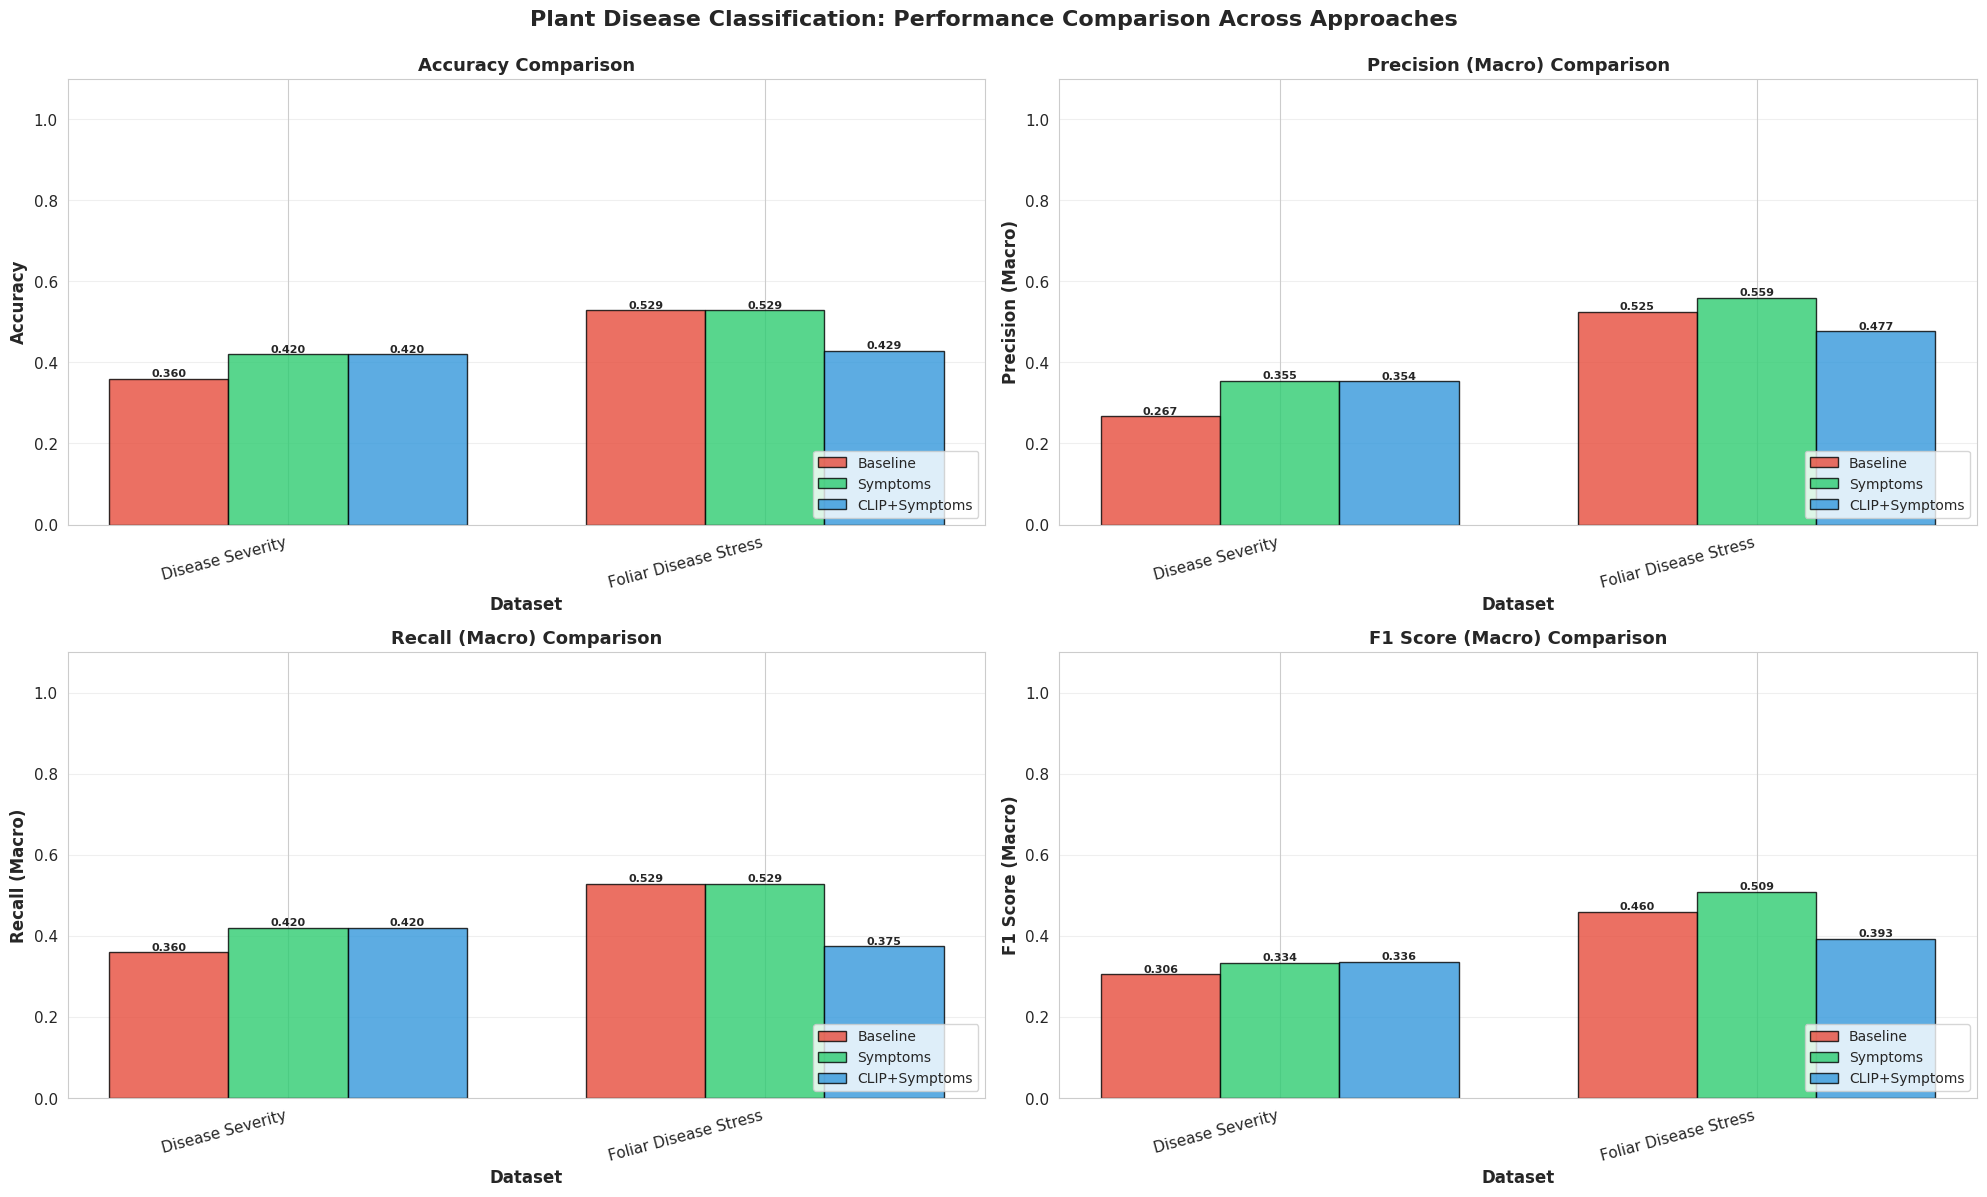

✓ Saved improvement heatmap to: /content/visualizations/improvement_heatmap.png


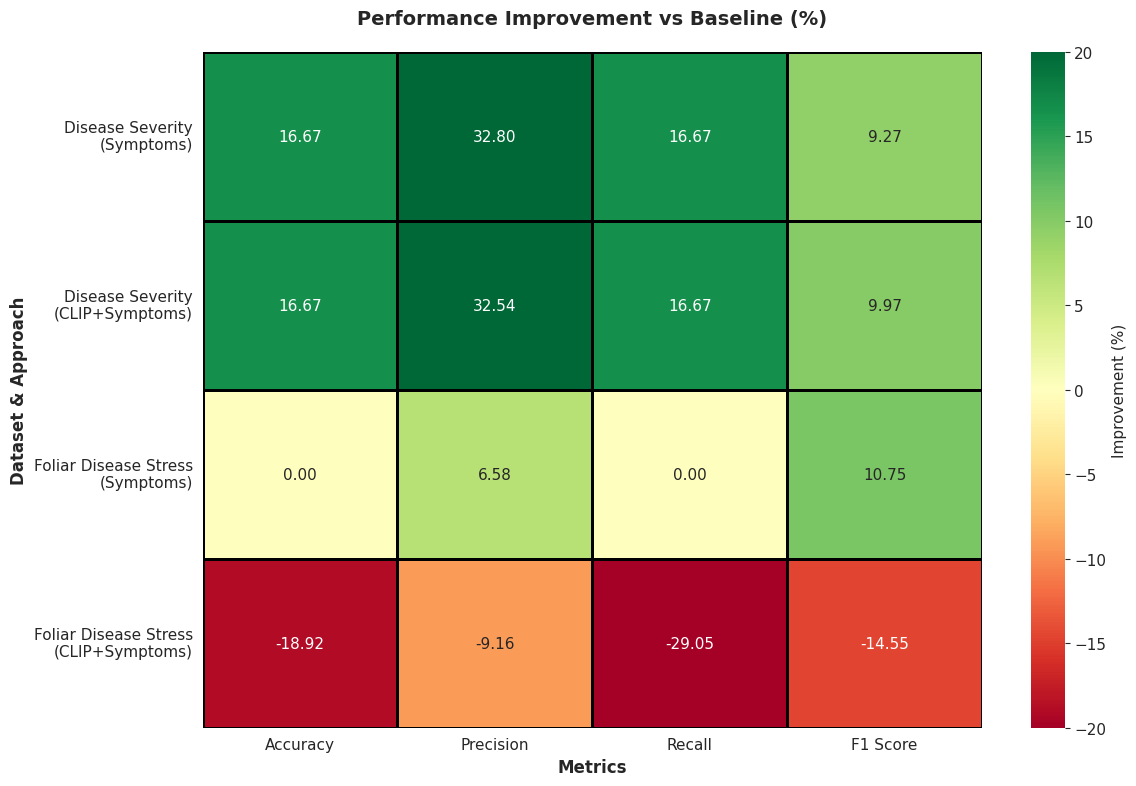

✓ Saved radar chart to: /content/visualizations/radar_comparison.png


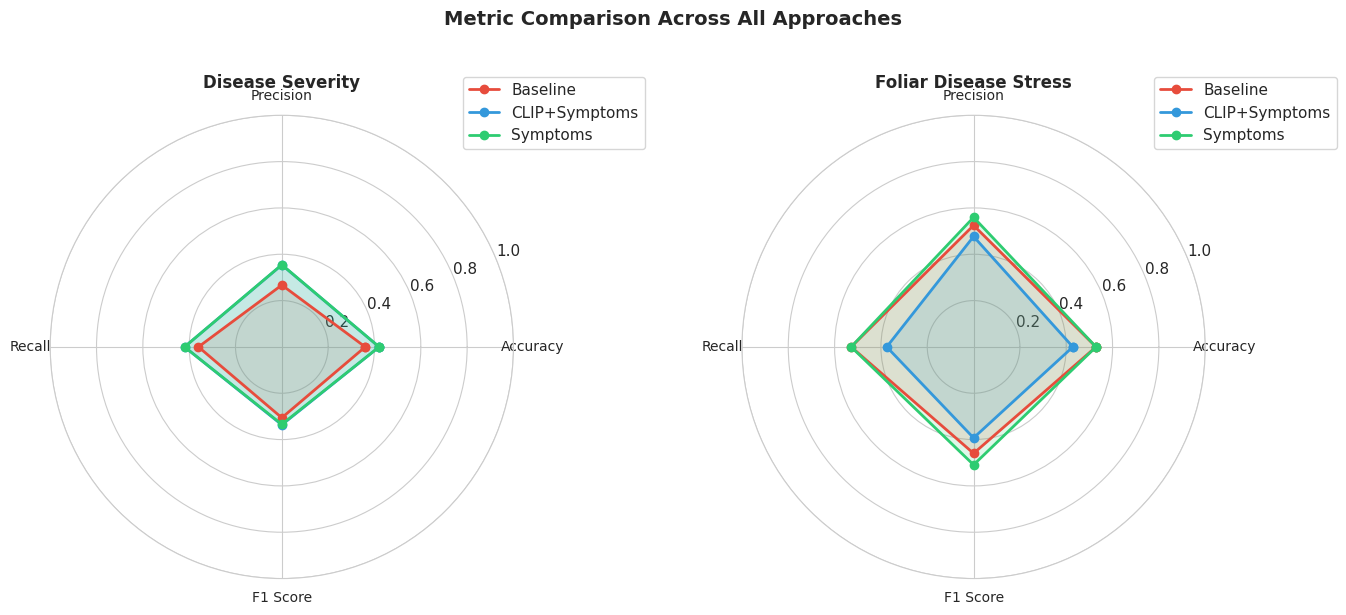

✓ Saved summary table to: /content/visualizations/summary_table.png


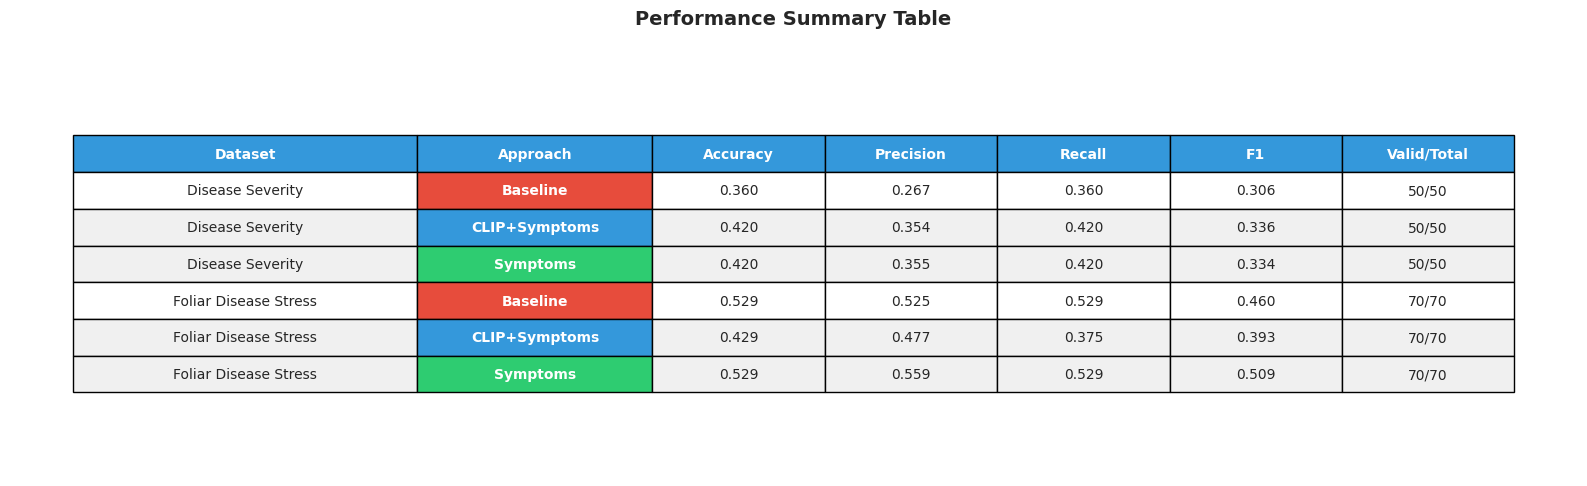


                         PERFORMANCE SUMMARY

────────────────────────────────────────────────────────────────────────────────
📊 DATASET: Disease Severity
────────────────────────────────────────────────────────────────────────────────

  BASELINE:
    • Accuracy:  0.3600 (36.00%)
    • Precision: 0.2671 (26.71%)
    • Recall:    0.3600 (36.00%)
    • F1 Score:  0.3059 (30.59%)
    • Valid Predictions: 50/50

  CLIP+SYMPTOMS:
    • Accuracy:  0.4200 (42.00%)
    • Precision: 0.3541 (35.41%)
    • Recall:    0.4200 (42.00%)
    • F1 Score:  0.3364 (33.64%)
    • Valid Predictions: 50/50

  SYMPTOMS:
    • Accuracy:  0.4200 (42.00%)
    • Precision: 0.3548 (35.48%)
    • Recall:    0.4200 (42.00%)
    • F1 Score:  0.3343 (33.43%)
    • Valid Predictions: 50/50

  📈 IMPROVEMENT VS BASELINE:
    CLIP+Symptoms:
      • Accuracy: +16.67%
      • F1 Score: +9.97%
    Symptoms:
      • Accuracy: +16.67%
      • F1 Score: +9.27%

────────────────────────────────────────────────────────────────

In [ ]:
"""
Comprehensive Visualization Script for Plant Disease Classification Results
Compares Baseline vs Symptoms vs CLIP+Symptoms approaches across multiple datasets and models
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# ============================================================================
# COLOR PALETTE - Professional and Colorblind-friendly
# ============================================================================

COLORS = {
    'baseline': '#E74C3C',          # Red for baseline
    'symptoms': '#2ECC71',          # Green for symptoms
    'clip_symptoms': '#3498DB',     # Blue for CLIP+symptoms
    'foliar': '#3498DB',            # Blue for foliar
    'severity': '#F39C12',          # Orange for severity
    'gpt4o-mini': '#9B59B6',        # Purple
    'gpt4o': '#1ABC9C',             # Teal
    'claude-sonnet': '#34495E',     # Dark gray
    'claude-haiku': '#95A5A6',      # Light gray
    'gemini-flash': '#E67E22',      # Orange
    'gemini-pro': '#16A085',        # Dark teal
    'llava': '#C0392B',             # Dark red
}

# ============================================================================
# METRIC EXTRACTION FUNCTIONS
# ============================================================================

def extract_metrics_from_csv(csv_path):
    """Extract predictions and compute metrics from CSV file"""
    try:
        df = pd.read_csv(csv_path)

        # Based on CSV structure:
        # Column 0 = index, Column 1 = image_path, Column 2 = true_label, Column 3 = prediction
        # Get true labels from column index 2 (third column)
        y_true = df.iloc[:, 2].tolist()

        # Find the predictions column (should be column 3 or column with "# of Shots 0")
        pred_col = None

        # First try to find by name
        for col in df.columns:
            if '# of Shots 0' in str(col):
                pred_col = col
                break

        # If not found by name, use column index 3
        if pred_col is None:
            if len(df.columns) > 3:
                pred_col = df.columns[3]
            else:
                print(f"Warning: Could not find predictions column in {csv_path}")
                return None

        y_pred = df[pred_col].tolist()

        # Filter out NA predictions
        valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'NA']
        y_true_filtered = [y_true[i] for i in valid_indices]
        y_pred_filtered = [y_pred[i] for i in valid_indices]

        if len(y_pred_filtered) == 0:
            return None

        # Compute metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        recall = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        f1 = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'valid_predictions': len(y_pred_filtered),
            'total_samples': len(y_pred)
        }

    except Exception as e:
        print(f"Error processing {csv_path}: {str(e)}")
        return None

# ============================================================================
# DATA LOADING
# ============================================================================

def inspect_csv_structure(csv_path):
    """Inspect CSV structure for debugging"""
    df = pd.read_csv(csv_path)
    print(f"\n{'='*80}")
    print(f"CSV Structure: {csv_path.name}")
    print(f"{'='*80}")
    print(f"Number of rows: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns):
        print(f"  [{i}] {col}")
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    print(f"{'='*80}\n")

def load_all_results(results_base_dir='/content/results'):
    """Load all results from the results directory"""
    results = []

    results_path = Path(results_base_dir)

    if not results_path.exists():
        print(f"Results directory not found: {results_base_dir}")
        return pd.DataFrame()

    # Iterate through model directories
    for model_dir in results_path.iterdir():
        if not model_dir.is_dir():
            continue

        model_name = model_dir.name

        # Look for CSV files
        for csv_file in model_dir.glob('*.csv'):
            filename = csv_file.stem

            # Skip METRICS files
            if 'METRICS' in filename:
                continue

            # Determine dataset type and approach
            if 'foliar' in filename.lower():
                dataset = 'Foliar Disease Stress'
            elif 'severity' in filename.lower():
                dataset = 'Disease Severity'
            else:
                continue

            # Determine approach
            if 'clip_reasoning' in filename.lower():
                approach = 'CLIP+Symptoms'
            elif 'baseline' in filename.lower():
                approach = 'Baseline'
            elif 'reasoning' in filename.lower():
                approach = 'Symptoms'
            else:
                continue

            # Extract metrics
            metrics = extract_metrics_from_csv(csv_file)

            if metrics:
                results.append({
                    'model': model_name,
                    'dataset': dataset,
                    'approach': approach,
                    **metrics
                })

    return pd.DataFrame(results)

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_comparison_bars(df, save_path='comparison_plots.png'):
    """Create comprehensive bar chart comparison"""

    if df.empty:
        print("No data to plot!")
        return

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Plant Disease Classification: Performance Comparison Across Approaches',
                 fontsize=16, fontweight='bold', y=0.995)

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_names = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)']

    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx // 2, idx % 2]

        # Prepare data for grouped bar chart
        datasets = sorted(df['dataset'].unique())
        approaches = ['Baseline', 'Symptoms', 'CLIP+Symptoms']

        # Filter to only include approaches that exist in the data
        available_approaches = [a for a in approaches if a in df['approach'].unique()]

        x = np.arange(len(datasets))
        width = 0.25 if len(available_approaches) == 3 else 0.35

        approach_values = {approach: [] for approach in available_approaches}

        for dataset in datasets:
            for approach in available_approaches:
                val = df[(df['dataset'] == dataset) & (df['approach'] == approach)][metric].values
                approach_values[approach].append(val[0] if len(val) > 0 else 0)

        # Create bars
        colors_map = {
            'Baseline': COLORS['baseline'],
            'Symptoms': COLORS['symptoms'],
            'CLIP+Symptoms': COLORS['clip_symptoms']
        }

        bars_list = []
        for i, approach in enumerate(available_approaches):
            offset = (i - len(available_approaches)/2 + 0.5) * width
            bars = ax.bar(x + offset, approach_values[approach], width,
                         label=approach, color=colors_map[approach],
                         alpha=0.8, edgecolor='black')
            bars_list.append(bars)

        # Add value labels on bars
        for bars in bars_list:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Customize
        ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_title(f'{metric_name} Comparison', fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=15, ha='right')
        ax.legend(loc='lower right', fontsize=10)
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved comparison plot to: {save_path}")
    plt.show()

def plot_improvement_heatmap(df, save_path='improvement_heatmap.png'):
    """Create heatmap showing improvement from baseline to other approaches"""

    if df.empty:
        print("No data to plot!")
        return

    # Calculate improvements
    improvements = []
    datasets = sorted(df['dataset'].unique())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Determine which approaches to compare
    approaches_to_compare = []
    if 'Symptoms' in df['approach'].unique():
        approaches_to_compare.append('Symptoms')
    if 'CLIP+Symptoms' in df['approach'].unique():
        approaches_to_compare.append('CLIP+Symptoms')

    for dataset in datasets:
        baseline = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')]

        for approach in approaches_to_compare:
            row = []
            comparison = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

            for metric in metrics:
                if not baseline.empty and not comparison.empty:
                    baseline_val = baseline[metric].values[0]
                    comparison_val = comparison[metric].values[0]
                    improvement = ((comparison_val - baseline_val) / baseline_val) * 100 if baseline_val > 0 else 0
                    row.append(improvement)
                else:
                    row.append(0)

            improvements.append([f"{dataset}\n({approach})"] + row)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))

    row_labels = [item[0] for item in improvements]
    data = [item[1:] for item in improvements]

    improvement_df = pd.DataFrame(data,
                                  columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                                  index=row_labels)

    sns.heatmap(improvement_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Improvement (%)'}, linewidths=2, linecolor='black',
                ax=ax, vmin=-20, vmax=20)

    ax.set_title('Performance Improvement vs Baseline (%)',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset & Approach', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved improvement heatmap to: {save_path}")
    plt.show()

def plot_radar_chart(df, save_path='radar_comparison.png'):
    """Create radar chart comparing all approaches across all metrics"""

    if df.empty:
        print("No data to plot!")
        return

    from math import pi

    datasets = sorted(df['dataset'].unique())
    approaches = sorted(df['approach'].unique())

    fig, axes = plt.subplots(1, len(datasets), figsize=(7*len(datasets), 6),
                            subplot_kw=dict(projection='polar'))

    if len(datasets) == 1:
        axes = [axes]

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    colors_map = {
        'Baseline': COLORS['baseline'],
        'Symptoms': COLORS['symptoms'],
        'CLIP+Symptoms': COLORS['clip_symptoms']
    }

    for idx, dataset in enumerate(datasets):
        ax = axes[idx]

        # Setup radar chart
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
        angles += angles[:1]

        for approach in approaches:
            values = []

            for metric in metrics:
                val = df[(df['dataset'] == dataset) & (df['approach'] == approach)][metric].values
                values.append(val[0] if len(val) > 0 else 0)

            values += values[:1]

            # Plot
            ax.plot(angles, values, 'o-', linewidth=2, label=approach,
                    color=colors_map.get(approach, '#000000'))
            ax.fill(angles, values, alpha=0.15, color=colors_map.get(approach, '#000000'))

        # Customize
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_labels, size=10)
        ax.set_ylim(0, 1)
        ax.set_title(dataset, fontsize=12, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax.grid(True)

    plt.suptitle('Metric Comparison Across All Approaches',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved radar chart to: {save_path}")
    plt.show()

def plot_summary_table(df, save_path='summary_table.png'):
    """Create a summary table visualization"""

    if df.empty:
        print("No data to plot!")
        return

    # Prepare summary data
    summary_data = []
    approaches = sorted(df['approach'].unique())

    for dataset in sorted(df['dataset'].unique()):
        for approach in approaches:
            row_data = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

            if not row_data.empty:
                summary_data.append([
                    dataset,
                    approach,
                    f"{row_data['accuracy'].values[0]:.3f}",
                    f"{row_data['precision'].values[0]:.3f}",
                    f"{row_data['recall'].values[0]:.3f}",
                    f"{row_data['f1'].values[0]:.3f}",
                    f"{row_data['valid_predictions'].values[0]}/{row_data['total_samples'].values[0]}"
                ])

    # Create figure
    fig, ax = plt.subplots(figsize=(16, len(summary_data) * 0.5 + 2))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=summary_data,
                    colLabels=['Dataset', 'Approach', 'Accuracy', 'Precision', 'Recall', 'F1', 'Valid/Total'],
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.22, 0.15, 0.11, 0.11, 0.11, 0.11, 0.11])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Color header
    for i in range(7):
        table[(0, i)].set_facecolor('#3498DB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color rows by approach
    colors_map = {
        'Baseline': COLORS['baseline'],
        'Symptoms': COLORS['symptoms'],
        'CLIP+Symptoms': COLORS['clip_symptoms']
    }

    for i, row in enumerate(summary_data, 1):
        approach = row[1]
        color = colors_map.get(approach, '#95A5A6')

        for j in range(7):
            if j == 1:  # Approach column
                table[(i, j)].set_facecolor(color)
                table[(i, j)].set_text_props(weight='bold', color='white')
            else:
                table[(i, j)].set_facecolor('#f0f0f0' if i % len(approaches) != 1 else 'white')

    plt.title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved summary table to: {save_path}")
    plt.show()

def print_text_summary(df):
    """Print a text-based summary to console"""

    if df.empty:
        print("No data available!")
        return

    print("\n" + "="*80)
    print(" "*25 + "PERFORMANCE SUMMARY")
    print("="*80)

    approaches = sorted(df['approach'].unique())

    for dataset in sorted(df['dataset'].unique()):
        print(f"\n{'─'*80}")
        print(f"📊 DATASET: {dataset}")
        print(f"{'─'*80}")

        for approach in approaches:
            row = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

            if not row.empty:
                print(f"\n  {approach.upper()}:")
                print(f"    • Accuracy:  {row['accuracy'].values[0]:.4f} ({row['accuracy'].values[0]*100:.2f}%)")
                print(f"    • Precision: {row['precision'].values[0]:.4f} ({row['precision'].values[0]*100:.2f}%)")
                print(f"    • Recall:    {row['recall'].values[0]:.4f} ({row['recall'].values[0]*100:.2f}%)")
                print(f"    • F1 Score:  {row['f1'].values[0]:.4f} ({row['f1'].values[0]*100:.2f}%)")
                print(f"    • Valid Predictions: {row['valid_predictions'].values[0]}/{row['total_samples'].values[0]}")

        # Calculate improvements vs baseline
        baseline = df[(df['dataset'] == dataset) & (df['approach'] == 'Baseline')]

        if not baseline.empty:
            print(f"\n  📈 IMPROVEMENT VS BASELINE:")

            for approach in approaches:
                if approach == 'Baseline':
                    continue

                comparison = df[(df['dataset'] == dataset) & (df['approach'] == approach)]

                if not comparison.empty:
                    acc_improvement = ((comparison['accuracy'].values[0] - baseline['accuracy'].values[0]) /
                                      baseline['accuracy'].values[0] * 100)
                    f1_improvement = ((comparison['f1'].values[0] - baseline['f1'].values[0]) /
                                     baseline['f1'].values[0] * 100)

                    print(f"    {approach}:")
                    print(f"      • Accuracy: {acc_improvement:+.2f}%")
                    print(f"      • F1 Score: {f1_improvement:+.2f}%")

    print("\n" + "="*80 + "\n")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main(inspect_first=False):
    """Main function to generate all visualizations

    Args:
        inspect_first: If True, show CSV structure before processing
    """

    print("\n" + "="*80)
    print(" "*20 + "VISUALIZATION SCRIPT STARTED")
    print("="*80 + "\n")

    # Optional: Inspect CSV structure
    if inspect_first:
        results_path = Path('/content/results')
        if results_path.exists():
            for model_dir in results_path.iterdir():
                if model_dir.is_dir():
                    for csv_file in model_dir.glob('*.csv'):
                        if 'METRICS' not in csv_file.stem:
                            inspect_csv_structure(csv_file)
                            break  # Only inspect first CSV from each model
                    break  # Only inspect first model

    # Load data
    print("📂 Loading results from /content/results...")
    df = load_all_results('/content/results')

    if df.empty:
        print("❌ No results found! Make sure CSV files exist in /content/results/MODEL_NAME/")
        return

    print(f"✓ Loaded {len(df)} result configurations")
    print(f"  - Models: {df['model'].unique().tolist()}")
    print(f"  - Datasets: {df['dataset'].unique().tolist()}")
    print(f"  - Approaches: {df['approach'].unique().tolist()}")

    # Create output directory
    output_dir = Path('/content/visualizations')
    output_dir.mkdir(exist_ok=True)

    print(f"\n📊 Generating visualizations...")

    # Generate all plots
    plot_comparison_bars(df, output_dir / 'comparison_bars.png')
    plot_improvement_heatmap(df, output_dir / 'improvement_heatmap.png')
    plot_radar_chart(df, output_dir / 'radar_comparison.png')
    plot_summary_table(df, output_dir / 'summary_table.png')

    # Print text summary
    print_text_summary(df)

    print("\n" + "="*80)
    print("✓✓✓ ALL VISUALIZATIONS COMPLETED!")
    print("="*80)
    print(f"\n📁 Output directory: {output_dir}")
    print(f"   Generated files:")
    print(f"   - comparison_bars.png")
    print(f"   - improvement_heatmap.png")
    print(f"   - radar_comparison.png")
    print(f"   - summary_table.png")
    print("\n")

if __name__ == "__main__":
    main()